In [1]:
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as pchs
from matplotlib.patches import Patch
import numpy as np
import os
import scipy
from scipy import stats
import seaborn as sb

In [2]:
def openSplayFiles(path):
    
    frames = []
    times = []
    angles = []
    
    for files in os.scandir(path):
        
        data = open(files, 'r')
        blanks = 0
        fileFs = []
        fileTs = []
        fileAs = []
        
        for line in data.readlines():
            
            iData = line.split()
            value = iData[0]
            valueWorks = True
            
            try:
                float(value)
            except:
                valueWorks = False
            
            if valueWorks == True:
                if blanks == 1:
                    fileTs.append(float(value)/60)
                elif blanks == 2:
                    fileAs.append(float(value))
            
            else:
                blanks += 1
        
        for i in range(len(fileTs)):
            fileFs.append(float(i))
        
        frames.append(fileFs)
        times.append(fileTs)
        angles.append(fileAs)
    
    return(frames, times, angles)




def openGroupsFiles(path):
    
    frames = []
    times = []
    groups = []
    
    for files in os.scandir(path):
        
        data = open(files, 'r')
        blanks = 0
        fileFs = []
        fileTs = []
        fileGs = []
        
        for line in data.readlines():
            
            iData = line.split()
            value = iData[0]
            valueWorks = True
            
            try:
                float(value)
            except:
                valueWorks = False
            
            if valueWorks == True:
                if blanks == 1:
                    fileTs.append(float(value)/60)
                elif blanks == 2:
                    fileGs.append(int(value))
            
            else:
                blanks += 1
        
        for i in range(len(fileTs)):
            fileFs.append(int(i))
        
        frames.append(fileFs)
        times.append(fileTs)
        groups.append(fileGs)
    
    return(frames, times, groups)




def openRepairFiles(path):
    
    times = []
    dists = []
    fileNum = 0
    sizes = []
    
    for files in os.scandir(path):
        
        data = open(files, 'r')
        blanks = 0
        fileTimes = []
        fileDists = []
        
        for line in data.readlines():
            
            iData = line.split()
            valueWorks = True
            
            try:
                float(iData[0])
            except:
                valueWorks = False
            
            if valueWorks == True:
                value = float(iData[0])
                if blanks == 1:
                    fileTimes.append(value/60)
                elif blanks == 2:
                    fileDists.append(value)
            
            else:
                blanks += 1
        
        times.append(fileTimes)
        dists.append(fileDists)
        sizes.append(len(fileTimes))
        fileNum += 1
        
    longVid = max(sizes)
    longList = 0
    
    for i in range(fileNum):
        if len(times[i]) == longVid:
            longList = i
    
    return(times, dists, longVid)




def combineData(times, data):
    
    allTimes = []
    allData = []
    
    for i in range(len(data)):
        
        timesI = times[i]
        dataI = data[i]
        
        for j in range(len(dataI)):
            allTimes.append(timesI[j])
            allData.append(dataI[j])
    
    return(allTimes, allData)




def resetTs(oldTs, possibleTs):
    
    newTs = []
    
    for i in range(len(oldTs)):
        
        oldTsI = oldTs[i]
        newTsI = []
        timeDiff = (oldTsI[len(oldTsI)-1]-oldTsI[0])/(len(oldTsI)-1)
        realT = 0
        
        for j in range(len(possibleTs)):
            if abs(60*timeDiff-possibleTs[j]) < 0.25:
                realT = possibleTs[j]
        
        for j in range(len(oldTsI)):
            newTsI.append(j*realT/60)
        
        newTs.append(newTsI)
    
    return(newTs)




def equalFRs(times, data, frameRate, threshold):
    
    timesFR = []
    dataFR = []
    
    for i in range(len(times)):
        
        timesI = times[i]
        dataI = data[i]
        
        if abs(timesI[1]-timesI[0]-frameRate) < threshold:
            timesFR.append(timesI)
            dataFR.append(dataI)
        
        else:
            
            timesFRi = []
            dataFRi = []
            dataTot = []
            maxTi = round(timesI[len(timesI)-1]/frameRate)+1
            
            for j in range(maxTi):
                timesFRi.append(j*frameRate)
                dataTot.append([])
            
            for j in range(len(timesI)):
                if timesI[1]-timesI[0]>frameRate and abs(abs(timesI[j]/frameRate-int(timesI[j]/frameRate))-0.5)<0.1:
                    dataTot[int(timesI[j]/frameRate)].append(dataI[j])
                    if int(timesI[j]/frameRate)+1 < len(dataTot):
                        dataTot[int(timesI[j]/frameRate)+1].append(dataI[j])
                else:
                    dataTot[round(timesI[j]/frameRate)].append(dataI[j])
            
            for j in range(maxTi):
                dataFRi.append(np.mean(dataTot[j]))
            
            timesFR.append(timesFRi)
            dataFR.append(dataFRi)
    
    return(timesFR, dataFR)




def smoothen(times, data, order):
    
    dt = []
    longDT = 0
    orders = []
    longOrder = 0
    
    for i in range(len(times)):
        dt.append(60*(times[i][1]-times[i][0]))
    
    for i in range(len(times)):
        orders.append(int(round(math.sqrt(order)/(60*(times[i][1]-times[i][0])))))
    
    for i in range(len(orders)):
        if orders[i]>longOrder:
            longOrder = orders[i]
    
    smoothData = []
    smooths = []
    counter = 0
    
    for i in range(len(data)):
        
        smoothData.append([])
        smooths.append([])
        dataI = data[i]
        
        for j in range(len(dataI)):
            smoothData[i].append(dataI[j])
    
    while counter<longOrder:
        
        for i in range(len(smoothData)):
            
            smooths.append([])
            LdI = len(data[i])
            smoothDataI = smoothData[i]
            
            if counter<orders[i]:
                
                if len(smoothDataI) > 6:
                    
                    smoothD0 = (20*smoothDataI[0] + 15*smoothDataI[1] + 6*smoothDataI[2] + smoothDataI[3])/42
                    smoothD1 = (15*smoothDataI[0] + 20*smoothDataI[1] + 15*smoothDataI[2] + 6*smoothDataI[3] + smoothDataI[4])/57
                    smoothD2 = (6*smoothDataI[0] + 15*smoothDataI[1] + 20*smoothDataI[2] + 15*smoothDataI[3] + 6*smoothDataI[4] + smoothDataI[5])/63
                    
                    smooths[i].append(smoothD0)
                    smooths[i].append(smoothD1)
                    smooths[i].append(smoothD2)
                    
                    for j in range(3,len(smoothData[i])-3):
                        
                        smoothDI = (smoothDataI[j-3] + 6*smoothDataI[j-2] + 15*smoothDataI[j-1] + 20*smoothDataI[j] + 15*smoothDataI[j+1] + 6*smoothDataI[j+2] + smoothDataI[j+3])/64
                        smooths[i].append(smoothDI)
                    
                    smoothDM2 = (smoothDataI[LdI-6] + 6*smoothDataI[LdI-5] + 15*smoothDataI[LdI-4] + 20*smoothDataI[LdI-3] + 15*smoothDataI[LdI-2] + 6*smoothDataI[LdI-1])/63
                    smoothDM1 = (smoothDataI[LdI-5] + 6*smoothDataI[LdI-4] + 15*smoothDataI[LdI-3] + 20*smoothDataI[LdI-2] + 15*smoothDataI[LdI-1])/57
                    smoothDM0 = (smoothDataI[LdI-4] + 6*smoothDataI[LdI-3] + 15*smoothDataI[LdI-2] + 20*smoothDataI[LdI-1])/42
                    
                    smooths[i].append(smoothDM2)
                    smooths[i].append(smoothDM1)
                    smooths[i].append(smoothDM0)
                
                else:
                    for j in range(len(smoothDataI)):
                        smooths[i].append(smoothDataI[j])
            
            else:
                for j in range(len(smoothDataI)):
                    smooths[i].append(smoothDataI[j])
            
            smoothData[i].clear()
            
            for j in range(len(smooths[i])):
                smoothData[i].append(smooths[i][j])
        
        smooths.clear()
        counter += 1
        
    return(smoothData)




def smoothenRepair(times, dists, order):
    
    orders = []
    longOrder = 0
    
    for i in range(len(times)):
        orders.append(int(round(math.sqrt(order)/(60*(times[i][1]-times[i][0])))))
    
    for i in range(len(orders)):
        if orders[i]>longOrder:
            longOrder = orders[i]
    
    smoothDists = []
    smooths = []
    counter = 0
    
    for i in range(len(dists)):
        
        smoothDists.append([])
        smooths.append([])
        
        for j in range(len(dists[i])):
            smoothDists[i].append(dists[i][j])
    
    while counter<longOrder:
        
        for i in range(len(smoothDists)):
            
            if counter<orders[i]:
                
                smooths.append([])
                
                smoothL0 = (20*smoothDists[i][0] + 15*smoothDists[i][1] + 6*smoothDists[i][2] + smoothDists[i][3])/42
                smoothL1 = (15*smoothDists[i][0] + 20*smoothDists[i][1] + 15*smoothDists[i][2] + 6*smoothDists[i][3] + smoothDists[i][4])/57
                smoothL2 = (6*smoothDists[i][0] + 15*smoothDists[i][1] + 20*smoothDists[i][2] + 15*smoothDists[i][3] + 6*smoothDists[i][4] + smoothDists[i][5])/63
                
                smooths[i].append(smoothL0)
                smooths[i].append(smoothL1)
                smooths[i].append(smoothL2)
                
                for j in range(3,len(smoothDists[i])-3):
                    smoothLI = (smoothDists[i][j-3] + 6*smoothDists[i][j-2] + 15*smoothDists[i][j-1] + 20*smoothDists[i][j] + 15*smoothDists[i][j+1] + 6*smoothDists[i][j+2] + smoothDists[i][j+3])/64
                    smooths[i].append(smoothLI)
                
                smoothLM2 = (smoothDists[i][len(dists[i])-6] + 6*smoothDists[i][len(dists[i])-5] + 15*smoothDists[i][len(dists[i])-4] + 20*smoothDists[i][len(dists[i])-3] + 15*smoothDists[i][len(dists[i])-2] + 6*smoothDists[i][len(dists[i])-1])/63
                smoothLM1 = (smoothDists[i][len(dists[i])-5] + 6*smoothDists[i][len(dists[i])-4] + 15*smoothDists[i][len(dists[i])-3] + 20*smoothDists[i][len(dists[i])-2] + 15*smoothDists[i][len(dists[i])-1])/57
                smoothLM0 = (smoothDists[i][len(dists[i])-4] + 6*smoothDists[i][len(dists[i])-3] + 15*smoothDists[i][len(dists[i])-2] + 20*smoothDists[i][len(dists[i])-1])/42
                
                smooths[i].append(smoothLM2)
                smooths[i].append(smoothLM1)
                smooths[i].append(smoothLM0)
            
            else:
                smooths.append([])
                for j in range(len(smoothDists[i])):
                    smooths[i].append(smoothDists[i][j])
            
            smoothDists[i].clear()
            
            for j in range(len(smooths[i])):
                smoothDists[i].append(smooths[i][j])
        
        smooths.clear()
        counter += 1
        
    return(smoothDists)




def addZeros(frames, times, angles, vidLs, frameRates):
    
    zeroFs = []
    zeroTs = []
    zeroAs = []
    
    for i in range(len(frames)):
        zeroFs.append(frames[i])
        zeroTs.append(times[i])
        zeroAs.append(angles[i])
    
    for i in range(len(vidLs)):
        
        framesI = []
        timesI = []
        anglesI = []
        
        for j in range(vidLs[i]):
            framesI.append(j)
            timesI.append(j*frameRates[i]/60)
            anglesI.append(0)
        
        zeroFs.append(framesI)
        zeroTs.append(timesI)
        zeroAs.append(anglesI)
    
    return(zeroFs, zeroTs, zeroAs)




def cutDataTs(times, data, minN):
    
    longest = [None]*minN
    
    for i in range(len(times)):
        
        placed = False
        
        for j in range(len(longest)):
            if (longest[j] == None or times[i][len(times[i])-1] > times[longest[j]][len(times[longest[j]])-1]) and placed == False:
                longest.insert(j,i)
                longest.pop(minN)
                placed = True
    
    maxT = times[longest[minN-1]][len(times[longest[minN-1]])-1]
    newTs = []
    newDs = []
    
    for i in range(len(times)):
        
        if i in longest:
            
            Ts = []
            Ds = []
            
            for j in range(len(times[i])):
                if times[i][j] <= maxT:
                    Ts.append(times[i][j])
                    Ds.append(data[i][j])
            
            newTs.append(Ts)
            newDs.append(Ds)
        
        else:
            newTs.append(times[i])
            newDs.append(data[i])
    
    return(newTs, newDs)




def normalTime(times, data):
    
    newTs = []
    newDs = []
    
    for i in range(len(times)):
        
        tI = []
        dI = []
        dList = []
        maxI = round(60*times[i][len(times[i])-1]/3.5)
        
        for j in range(maxI+1):
            tI.append(3.5*j/60)
            dList.append([])
        
        for j in range(len(times[i])):
            dList[round(60*times[i][j]/3.5)].append(data[i][j])
        
        for j in range(maxI+1):
            if len(dList[j]) > 0:
                dI.append(np.mean(dList[j]))
            elif j == 0:
                dI.append(np.mean(dList[1]))
            elif j == maxI:
                dI.append(np.mean(dList[maxI-1]))
            else:
                dI.append((np.mean(dList[j-1])+np.mean(dList[j+1]))/2)
        
        newTs.append(tI)
        newDs.append(dI)
    
    return(newTs, newDs)




def binCompData(vs, angles):
    
    vsNtPts = 0
    vsYtPts = 0
    vsNt = []
    vsYt = []
    
    for i in range(len(angles)):
        
        if len(vs[i]) >= len(angles[i]):
            for j in range(len(angles[i])):
                if angles[i][j] > 15:
                    vsYtPts += 1
                    vsYt.append(vs[i][j])
                else:
                    vsNtPts += 1
                    vsNt.append(vs[i][j])
        
        else:
            for j in range(len(vs[i])):
                if angles[i][j] > 15:
                    vsYtPts += 1
                    vsYt.append(vs[i][j])
                else:
                    vsNtPts += 1
                    vsNt.append(vs[i][j])
    
    return(vsNt, vsYt, vsNtPts, vsYtPts)




def maxes(times, dists):
    
    maxTimes = []
    maxDists = []
    
    for i in range(len(times)):
        
        maxTimeI = 0
        maxDistI = 0
        
        for j in range(len(times[i])):
            if dists[i][j]>maxDistI:
                maxTimeI = times[i][j]
                maxDistI = dists[i][j]
        
        maxTimes.append(maxTimeI)
        maxDists.append(maxDistI)
    
    return(maxTimes, maxDists)




def dCKD(dists):
    
    dCKDs = []
    
    for i in range(len(dists)):
        dCKDsI = []
        for j in range(len(dists[i])):
            dCKDsI.append(dists[i][0]-dists[i][j])
        dCKDs.append(dCKDsI)
    
    return(dCKDs)




def splayings(times, angles):
    
    occurances = []
    occurNs = [0,0,0,0]
    occurFracs = []
    splayTs = []
    splayTsExp = []
    totalSTs = []
    maxAs = []
    
    for i in range(len(times)):
        
        startT = 0
        splayTsI = []
        timesI = times[i]
        anglesI = angles[i]
        maxAI = 0
        
        for j in range(len(timesI)):
            
            if startT == 0:
                if anglesI[j] >= 15:
                    startT = timesI[j]
            
            elif anglesI[j] < 15 or j == len(timesI)-1:
                splayTsI.append(timesI[j]-startT)
                splayTsExp.append(timesI[j]-startT)
                startT = 0
            
            if anglesI[j] > maxAI:
                maxAI = anglesI[j]
        
        occurances.append(len(splayTsI))
        splayTs.append(splayTsI)
        totalSTs.append(np.sum(splayTsI))
        maxAs.append(maxAI)
        
        if len(splayTsI) > 3:
            occurNs[3] += 1
        else:
            occurNs[len(splayTsI)] += 1
        
    for i in range(4):
        occurFracs.append(occurNs[i]/np.sum(occurNs))
    
    return(occurances, occurNs, occurFracs, splayTs, splayTsExp, totalSTs, maxAs)




def velocities(times, dists):
    
    vs = []
    maxVTs = []
    maxVs = []
    
    for i in range(len(times)):
        
        vs.append([])
        maxTI = 0
        maxVI = 0
        
        for j in range(len(times[i])):
            
            if j==0:
                Vij = -(dists[i][1]-dists[i][0])/(times[i][1]-times[i][0])
            elif j==len(times[i])-1:
                Vij = -(dists[i][j]-dists[i][j-1])/(times[i][j]-times[i][j-1])
            else:
                Vij = -(dists[i][j+1]-dists[i][j-1])/(times[i][j+1]-times[i][j-1])
            
            if Vij>maxVI:
                maxTI = times[i][j]
                maxVI = Vij
            
            vs[i].append(Vij)
        
        maxVTs.append(maxTI)
        maxVs.append(maxVI)
    
    return(vs, maxVTs, maxVs)




def WTanalysis(no, yes, timesR, distsR, timesEx, distsEx, timesS, anglesS, possibleTs):
    
    noNorm = no/(no+yes)
    yesNorm = yes/(no+yes)
    low = (yes-math.sqrt(yes))/(no+yes)
    high = (yes+math.sqrt(yes))/(no+yes)
    
    timesR = resetTs(timesR, possibleTs)
    timesEx = resetTs(timesEx, possibleTs)
    timesS = resetTs(timesS, possibleTs)
    
    distsR10 = smoothenRepair(timesR, distsR, 10)
    maxTsR, maxVsR = maxes(timesR, distsR10)
    anglesS10 = smoothen(timesS, anglesS, 10)
    maxTsS, maxAsS = maxes(timesS, anglesS10)
    
    times0R = []
    dists0 = []
    times0S = []
    angles0 = []
    for i in range(len(timesS)):
        times0S.append(timesS[i])
        angles0.append(anglesS[i])
    for i in range(len(timesR)):
        times0R.append(timesR[i])
        dists0.append(distsR[i])
    for i in range(len(timesEx)):
        times0R.append(timesEx[i])
        dists0.append(distsEx[i])
    for i in range(len(timesEx)):
        zeroTs = []
        zeros = []
        for j in range(len(timesEx[i])):
            zeroTs.append(timesEx[i][j])
            zeros.append(0)
        times0S.append(zeroTs)
        angles0.append(zeros)
    
    dists010 = smoothenRepair(times0R, dists0, 10)
    vs0, maxVTs0, maxVs0 = velocities(times0R, dists010)
    times0RN, vs0Norm = normalTime(times0R, vs0)
    angles010 = smoothen(times0S, angles0, 10)
    times0SN, angles0Norm = normalTime(times0S, angles010)
    vsNtF, vsYtF, vsNtPtsF, vsYtPtsF = binCompData(vs0Norm, angles0Norm)
    
    weightsN = []
    weightsY = []
    for i in range(len(vsNtF)):
        weightsN.append(1/vsNtPtsF)
    for i in range(len(vsYtF)):
        weightsY.append(1/vsYtPtsF)
    
    ynSt, ynSp = scipy.stats.ttest_ind(vsNtF, vsYtF)
    
    return(noNorm, yesNorm, low, high, maxTsR, maxTsS, vsNtF, vsYtF, vsNtPtsF, vsYtPtsF, weightsN, weightsY, ynSp)




def runSplay(frames, times, angles, missVidLs, missFrameRates):
    
    angles10 = smoothen(times, angles, 10)
    frames0, times0, angles0 = addZeros(frames, times, angles, missVidLs, missFrameRates)
    angles010 = smoothen(times0, angles0, 10)
    
    if len(times) < 5:
        timesT = times
        anglesT = angles
        timesT0 = times0
        anglesT0 = angles0
    else:
        timesT, anglesT = cutDataTs(times, angles, 5)
        timesT0, anglesT0 = cutDataTs(times0, angles0, 5)
    
    t0Times, t0Stubs, t0Angles, t0LowAng, t0HighAng, t0MedAng, t0TopAng = timeData(times0, angles0)
    tTimesT, tStubsT, tAnglesT, tLowAngT, tHighAngT, t0MedAngT, tTopAngT = timeData(timesT, anglesT)
    t0TimesT, t0StubsT, t0AnglesT, t0LowAngT, t0HighAngT, t0MedAngT, t0TopAngT = timeData(timesT0, anglesT0)
    
    #return(angles10, times0, angles0, angles010, t0Times, t0Angles, t0LowAng, t0HighAng, tTimesT, tAnglesT, tLowAngT, tHighAngT, t0TimesT, t0AnglesT, t0LowAngT, t0HighAngT)
    return(angles10, times0, angles0, angles010, t0Times, t0Angles, t0LowAng, t0HighAng, tTimesT, tAnglesT, tLowAngT, tHighAngT, t0TimesT, t0AnglesT, t0LowAngT, t0HighAngT)




def runGroups(times, groups, frameRate, possibleTs):
    
    timesG = resetTs(times, possibleTs)
    tTimesG, tStubsG, tGroups, tGroupsFs, tGroupsFsPlot, tavgGs = timeDataG(timesG, groups, frameRate)
    
    return(tTimesG, tGroupsFsPlot, tStubsG)




def runRepair(timesOld, distsOld):
    
    #times = []
    #dists = []
    dckds = []
    
    for i in range(len(timesOld)):
        timesI, distsI = combineData(timesOld[i], distsOld[i])
        #times.append(timesI)
        #dists.append(distsI)
        dckds.append(dCKD(distsI))
    
    #for i in range(len(times)):
        #dckdsI = dCKD(dists[i])
        #dckds.append(dckdsI)
    
    return(dckds)




def swarm(namesIn, dataIn):
    
    names = []
    data = []
    
    for i in range(len(dataIn)):
        namesI = namesIn[i]
        dataI = dataIn[i]
        for j in range(len(dataI)):
            names.append(namesI)
            data.append(dataI[j])
    
    return(names, data)




def boxes(names, data):
    
    types = []
    std = []
    error = []
    
    for i in range(len(data)):
        dataI = data[i]
        types.append(names[i])
        std.append([np.mean(dataI), np.mean(dataI)-2*np.std(dataI), np.mean(dataI)+2*np.std(dataI)])
        error.append([np.mean(dataI), np.mean(dataI)-2*np.std(dataI)/np.sqrt(len(dataI)), np.mean(dataI)+2*np.std(dataI)/np.sqrt(len(dataI))])
    
    return(types, std, error)




def swarmTE(names, times0, angles0, angles010, frameRate, threshold):
    
    times0FR = []
    angles0FR = []
    for i in range(len(times0)):
        times0FRi, angles0FRi = equalFRs(times0[i], angles0[i], frameRate, threshold)
        times0FR.append(times0FRi)
        angles0FR.append(angles0FRi)
    
    totalSTs = []
    splayTsExp = []
    totalSTsFR = []
    splayTsExpFR = []
    for i in range(len(times0)):
        splayOccursI, splayOccurNsI, splayOccurFracsI, splayTsI, splayTsExpI, totalSTsI, maxAsI = splayings(times0[i], angles010[i])
        splayOccursFRi, splayOccurNsFRi, splayOccurFracsFRi, splayTsFRi, splayTsExpFRi, totalSTsFRi, maxAsFRi = splayings(times0FR[i], angles0FR[i])
        totalSTs.append(totalSTsI)
        splayTsExp.append(splayTsExpI)
        totalSTsFR.append(totalSTsFRi)
        splayTsExpFR.append(splayTsExpFRi)
    
    namesK = []
    totalSTsK = []
    splayTsExpK = []
    totalSTsKFR = []
    splayTsExpKFR = []
    for i in range(len(times0)):
        if i==0 or i==4 or i==5:
            namesK.append(names[i])
            totalSTsK.append(totalSTs[i])
            splayTsExpK.append(splayTsExp[i])
            totalSTsKFR.append(totalSTsFR[i])
            splayTsExpKFR.append(splayTsExpFR[i])
    
    swarmTypesT, swarmTsT = swarm(names, totalSTs)
    swarmTypesTFR, swarmTsTFR = swarm(names, totalSTsFR)
    swarmTypesE, swarmTsE = swarm(names, splayTsExp)
    swarmTypesEFR, swarmTsEFR = swarm(names, splayTsExpFR)
    swarmTypesTK, swarmTsTK = swarm(namesK, totalSTsK)
    swarmTypesTKFR, swarmTsTKFR = swarm(namesK, totalSTsKFR)
    swarmTypesEK, swarmTsEK = swarm(namesK, splayTsExpK)
    swarmTypesEKFR, swarmTsEKFR = swarm(namesK, splayTsExpKFR)
    
    tBoxTypes, tDBox, tEBox = boxes(names, totalSTs)
    tBoxTypesFR, tDBoxFR, tEBoxFR = boxes(names, totalSTsFR)
    eBoxTypes, eDBox, eEBox = boxes(names, splayTsExp)
    eBoxTypesFR, eDBoxFR, eEBoxFR = boxes(names, splayTsExpFR)
    tBoxTypesK, tDBoxK, tEBoxK = boxes(namesK, totalSTsK)
    tBoxTypesKFR, tDBoxKFR, tEBoxKFR = boxes(namesK, totalSTsKFR)
    eBoxTypesK, eDBoxK, eEBoxK = boxes(namesK, splayTsExpK)
    eBoxTypesKFR, eDBoxKFR, eEBoxKFR = boxes(namesK, splayTsExpKFR)
    
    tPs = pVals(totalSTs)
    tPsFR = pVals(totalSTsFR)
    ePs = pVals(splayTsExp)
    ePsFR = pVals(splayTsExpFR)
    tPsK = pVals(totalSTsK)
    tPsKFR = pVals(totalSTsKFR)
    ePsK = pVals(splayTsExpK)
    ePsKFR = pVals(splayTsExpKFR)
    
    return(swarmTypesT, swarmTsT, tBoxTypes, tEBox, swarmTypesE, swarmTsE, eBoxTypes, eEBox,
           swarmTypesTK, swarmTsTK, tBoxTypesK, tEBoxK, swarmTypesEK, swarmTsEK, eBoxTypesK, eEBoxK,
           swarmTypesTFR, swarmTsTFR, tBoxTypesFR, tEBoxFR, swarmTypesEFR, swarmTsEFR, eBoxTypesFR, eEBoxFR,
           swarmTypesTKFR, swarmTsTKFR, tBoxTypesKFR, tEBoxKFR, swarmTypesEKFR, swarmTsEKFR, eBoxTypesKFR, eEBoxKFR,
           tPs, ePs, tPsK, ePsK, tPsFR, ePsFR, tPsKFR, ePsKFR)




def swarmTEnoK(names, times0, angles0, angles010, frameRate, threshold):
    
    times0FR = []
    angles0FR = []
    for i in range(len(times0)):
        times0FRi, angles0FRi = equalFRs(times0[i], angles0[i], frameRate, threshold)
        times0FR.append(times0FRi)
        angles0FR.append(angles0FRi)
    
    totalSTs = []
    splayTsExp = []
    totalSTsFR = []
    splayTsExpFR = []
    for i in range(len(times0)):
        splayOccursI, splayOccurNsI, splayOccurFracsI, splayTsI, splayTsExpI, totalSTsI, maxAsI = splayings(times0[i], angles010[i])
        splayOccursFRi, splayOccurNsFRi, splayOccurFracsFRi, splayTsFRi, splayTsExpFRi, totalSTsFRi, maxAsFRi = splayings(times0FR[i], angles0FR[i])
        totalSTs.append(totalSTsI)
        splayTsExp.append(splayTsExpI)
        totalSTsFR.append(totalSTsFRi)
        splayTsExpFR.append(splayTsExpFRi)
    
    swarmTypesT, swarmTsT = swarm(names, totalSTs)
    swarmTypesTFR, swarmTsTFR = swarm(names, totalSTsFR)
    swarmTypesE, swarmTsE = swarm(names, splayTsExp)
    swarmTypesEFR, swarmTsEFR = swarm(names, splayTsExpFR)
    
    tBoxTypes, tDBox, tEBox = boxes(names, totalSTs)
    tBoxTypesFR, tDBoxFR, tEBoxFR = boxes(names, totalSTsFR)
    eBoxTypes, eDBox, eEBox = boxes(names, splayTsExp)
    eBoxTypesFR, eDBoxFR, eEBoxFR = boxes(names, splayTsExpFR)
    
    tPs = pVals(totalSTs)
    tPsFR = pVals(totalSTsFR)
    ePs = pVals(splayTsExp)
    ePsFR = pVals(splayTsExpFR)
    
    return(swarmTypesT, swarmTsT, tBoxTypes, tEBox, swarmTypesE, swarmTsE, eBoxTypes, eEBox,
           swarmTypesTFR, swarmTsTFR, tBoxTypesFR, tEBoxFR, swarmTypesEFR, swarmTsEFR, eBoxTypesFR, eEBoxFR,
           tPs, ePs, tPsFR, ePsFR)




def integrateAng(times, data):
    
    ints = []
    avgInts = []
    lowInts = []
    highInts = []
    
    for i in range(len(times)):
        
        timesI = times[i]
        dataI = data[i]
        intsI = []
        
        for j in range(len(timesI)):
            timesIJ = timesI[j]
            intsI.append(np.sum(dataI[j])*(timesIJ[1]-timesIJ[0]))
        
        ints.append(intsI)
        avgI = np.mean(intsI)
        avgInts.append(np.mean(intsI))
        eInts = np.std(intsI)/math.sqrt(len(intsI))
        lowInts.append(avgI-eInts)
        highInts.append(avgI+eInts)
    
    return(ints, avgInts, lowInts, highInts)




def integrateAT(times, data, T):
    
    avgTimes = []
    ints = []
    avgInts = []
    lowInts = []
    highInts = []
    
    for i in range(len(times)):
        
        avgTimesI = []
        intsI = []
        avgIsI = []
        lowIsI = []
        highIsI = []
        
        timesI = times[i]
        dataI = data[i]
        N = len(timesI)
        totalVs = []
        condenseVs = []
        
        maxT = 0
        for j in range(N):
            if timesI[j][len(timesI[j])-1] > maxT:
                maxT = timesI[j][len(timesI[j])-1]
        
        for j in range(N):
            
            intsIJ = []
            condenseIJ = []
            timesIJ = timesI[j]
            dataIJ = dataI[j]
            timeDiff = timesIJ[1]
            frames = int(maxT/timeDiff+1)
            totalV = 0
            counter = 0
            holdV = 0
            holding = False
            
            for k in range(frames):
                
                if k < len(timesIJ):
                    totalV += dataIJ[k]
                intV = totalV*timeDiff
                
                if k < len(timesIJ):
                    intsIJ.append(intV)
                
                if timeDiff > T:
                    if holding == True:
                        condenseIJ.append((holdV+intV)/2)
                        condenseIJ.append(intV)
                        counter += 2
                        holdV = 0
                        holding = False
                    elif abs(k*timeDiff-counter*T) > T/3:
                        condenseIJ.append(intV)
                        counter += 1
                        holdV = intV
                        holding = True
                    else:
                        condenseIJ.append(intV)
                        counter += 1
                        holdV = 0
                        holding = False
                
                else:
                    if abs(k*timeDiff-counter*T) < timeDiff/2:
                        condenseIJ.append(intV)
                        counter += 1
                        holdV = 0
                        holding = False
                    elif abs(abs(k*timeDiff-counter*T)-timeDiff/2) < 0.00000001/60:
                        if holding == True:
                            condenseIJ.append((holdV+intV)/2)
                            holdV = 0
                            counter += 1
                            holding = False
                        else:
                            holdV = intV
                            holding = True
                    else:
                        holdV = 0
                        holding = False
            
            intsI.append(intsIJ)
            condenseVs.append(condenseIJ)
        
        zeroL = len(condenseVs[0])
        
        for j in range(zeroL):
            
            combineVs = []
            for k in range(N):
                if len(condenseVs[k]) < zeroL:
                    condenseVs[k].append(condenseVs[k][zeroL-2])
                combineVs.append(condenseVs[k][j])
            
            avgTimesI.append(j*T)
            avgI = np.mean(combineVs)
            eI = np.std(combineVs)/math.sqrt(len(combineVs))
            avgIsI.append(avgI)
            lowIsI.append(avgI-eI)
            highIsI.append(avgI+eI)
        
        avgTimes.append(avgTimesI)
        ints.append(intsI)
        avgInts.append(avgIsI)
        lowInts.append(lowIsI)
        highInts.append(highIsI)
    
    return(avgTimes, ints, avgInts, lowInts, highInts)




def timeData(times, angles):
    
    tTimes = []
    tStubNum = []
    tAngles = []
    avgAngles = []
    lowAngles = []
    highAngles = []
    medAngles = []
    topAngles = []
    tAs = []
    maxT = 0
    
    for i in range(len(times)):
        tAs.append([])
        if times[i][len(times[i])-1] > maxT:
            maxT = times[i][len(times[i])-1]
    
    maxI = int(round(60*maxT/3.5))
    
    for i in range(maxI+1):
        tTimes.append(3.5*i/60)
        tAngles.append([])
        count = 0
        for j in range(len(times)):
            tAs[j].append([])
            if times[j][len(times[j])-1] >= 3.5*i:
                count += 1
        tStubNum.append(count)
    
    for i in range(len(times)):
        for j in range(len(times[i])):
            time = int(round(60*times[i][j]/3.5))
            tAs[i][time].append(angles[i][j])
    
    for i in range(len(tAs)):
        for j in range(len(tAs[i])):
            if len(tAs[i][j]) > 0:
                tAngles[j].append(np.mean(tAs[i][j]))
    
    for i in range(len(tAngles)):
        if len(tAngles[i]) == 0:
            if i == 0:
                tAngles[i].append(np.mean(tAngles[i+1]))
            elif i == len(tAngles)-1:
                tAngles[i].append(np.mean(tAngles[i-1]))
            else:
                tAngles[i].append((np.mean(tAngles[i-1])+np.mean(tAngles[i+1]))/2)
        tAnglesI = tAngles[i]
        avgAnglesI = np.mean(tAnglesI)
        eAngles = np.std(tAnglesI)/math.sqrt(len(tAnglesI))
        avgAngles.append(avgAnglesI)
        lowAngles.append(avgAnglesI-eAngles)
        highAngles.append(avgAnglesI+eAngles)
        medAngles.append(np.median(tAnglesI))
        topAngles.append(np.amax(tAnglesI))
    
    return(tTimes, tStubNum, avgAngles, lowAngles, highAngles, medAngles, topAngles)




def timeDataG(times, groups, T):
    
    tTimes = []
    tStubNum = []
    tGroups = []
    tGroupsFs = []
    tGroupsFsPlot = [[],[],[]]
    tAvgGroups = []
    newGs = []
    
    for i in range(len(times)):
        
        newGroups = []
        newGs.append([])
        
        for j in range(round(times[i][len(times[i])-1]/T)+1):
            newGroups.append([])
        
        for j in range(len(times[i])):
            newGroups[int(round(times[i][j]/T))].append(groups[i][j])
        
        for j in range(len(newGroups)):
            if len(newGroups[j]) == 0:
                newGs[i].append(int(round((np.mean(newGroups[j-1])+np.mean(newGroups[j+1]))/2)))
            else:
                newGs[i].append(int(round(np.mean(newGroups[j]))))
    
    maxT = 0
    
    for i in range(len(times)):
        if times[i][len(times[i])-1] > maxT:
            maxT = times[i][len(times[i])-1]
    
    maxI = int(round(maxT/T)+1)
    
    for i in range(maxI):
        tTimes.append(i*T)
        tGroups.append([0]*3)
        
    for i in range(len(newGs)):
        for j in range(len(newGs[i])):
            tGroups[j][newGs[i][j]-1] += 1
    
    for i in range(len(tGroups)):
        
        groupsI = tGroups[i]
        stubNumI = np.sum(groupsI)
        groupsFsI = []
        totalGsI = 0
        
        for j in range(3):
            totalGsI += (j+1)*groupsI[j]
            groupsFsI.append(groupsI[j]/stubNumI)
            tGroupsFsPlot[j].append(2-np.sum(groupsFsI))
        
        tStubNum.append(stubNumI)
        tGroupsFs.append(groupsFsI)
        tAvgGroups.append(totalGsI/stubNumI)
    
    return(tTimes, tStubNum, tGroups, tGroupsFs, tGroupsFsPlot, tAvgGroups)




def timeDataD(data, T):
    
    #failCount = 0
    
    avgDs = []
    lowDs = []
    highDs = []
    
    for i in range(len(data)):
        
        distsI = []
        dataI = data[i]
        N = len(dataI)
        
        for j in range(N):
            dataIJ = dataI[j]
            distsI.append(dataIJ[len(dataIJ)-1])
            #distsI.append(-dataIJ[len(dataIJ)-1])
            #if len(dataIJ) < 1:
                #distsI.append(distsI[len(distsI)-1])
                #failCount += 1
            #else:
                #distsI.append(-dataIJ[len(dataIJ)-1])
        
        avgD = np.mean(distsI)
        eI = np.std(distsI)/math.sqrt(len(distsI))
        avgDs.append(avgD)
        lowDs.append(avgD-eI)
        highDs.append(avgD+eI)
        
        #print(failCount)
    
    return(avgDs, lowDs, highDs)




def pVals(data):
    
    ps = []
    for i in range(len(data)-1):
        iT, iP = scipy.stats.ttest_ind(data[0], data[i+1])
        ps.append(iP)
    
    return(ps)




def AngleVsDist(times, dists, angles, possibleTs, dStep, dStepInt, distL, dckdL, offset):
    
    dckds = []
    for i in range(len(dists)):
        dckds.append(dCKD(dists[i]))
    
    distXs = []
    dckdXs = []
    distXsInt = []
    dckdXsInt = []
    
    distXsInd = []
    dckdXsInd = []
    distAsInd = []
    dckdAsInd = []
    distXsIntInd = []
    dckdXsIntInd = []
    distAsIntInd = []
    dckdAsIntInd = []
    distAsNormInd = []
    dckdAsNormInd = []
    
    distAvgAs = []
    distLowAs = []
    distHighAs = []
    dckdAvgAs = []
    dckdLowAs = []
    dckdHighAs = []
    distAvgAsInt = []
    distLowAsInt = []
    distHighAsInt = []
    dckdAvgAsInt = []
    dckdLowAsInt = []
    dckdHighAsInt = []
    distAvgAsNorm = []
    distLowAsNorm = []
    distHighAsNorm = []
    dckdAvgAsNorm = []
    dckdLowAsNorm = []
    dckdHighAsNorm = []
    
    for i in range(int(distL/dStep)):
        distXs.append(distL-i*dStep-dStep/2)
    for i in range(int(dckdL/dStep)):
        dckdXs.append(dStep/2+i*dStep-offset)
    for i in range(int(distL/dStepInt)):
        distXsInt.append(distL-i*dStepInt-dStepInt/2)
    for i in range(int(dckdL/dStepInt)):
        dckdXsInt.append(dStepInt/2+i*dStepInt-offset)
    
    for i in range(len(times)):
        
        distAsFullI = []
        dckdAsFullI = []
        distAsIntFullI = []
        dckdAsIntFullI = []
        distAsNormFullI = []
        dckdAsNormFullI = []
        distXsIndI = []
        dckdXsIndI = []
        distAsIndI = []
        dckdAsIndI = []
        distXsIntIndI = []
        dckdXsIntIndI = []
        distAsIntIndI = []
        dckdAsIntIndI = []
        distAsNormIndI = []
        dckdAsNormIndI = []
        
        for n in range(len(distXs)):
            distAsFullI.append([])
        for n in range(len(dckdXs)):
            dckdAsFullI.append([])
        for n in range(len(distXsInt)):
            distAsIntFullI.append([])
            distAsNormFullI.append([])
        for n in range(len(dckdXsInt)):
            dckdAsIntFullI.append([])
            dckdAsNormFullI.append([])
        
        timesI = times[i]
        distsI = dists[i]
        dckdsI = dckds[i]
        anglesI = angles[i]
        
        for j in range(len(timesI)):
            
            distXsIndIJ = []
            dckdXsIndIJ = []
            distAsIndIJ = []
            dckdAsIndIJ = []
            distXsIntIndIJ = []
            dckdXsIntIndIJ = []
            distAsIntIndIJ = []
            dckdAsIntIndIJ = []
            distAsNormIndIJ = []
            dckdAsNormIndIJ = []
            
            timesIJ = timesI[j]
            distsIJ = distsI[j]
            dckdsIJ = dckdsI[j]
            anglesIJ = anglesI[j]
            
            timeDiff = timesIJ[1]-timesIJ[0]
            tStep = 0
            tGap = 1
            for n in range(len(possibleTs)):
                if abs(possibleTs[n]/60-timeDiff) < tGap:
                    tGap = abs(possibleTs[n]/60-timeDiff)
                    tStep = possibleTs[n]/60
            
            comboDist = []
            comboDCKD = []
            comboDistInt = []
            comboDCKDInt = []
            for n in range(len(distXs)):
                comboDist.append([])
            for n in range(len(dckdXs)):
                comboDCKD.append([])
            for n in range(len(distXsInt)):
                comboDistInt.append([])
            for n in range(len(dckdXsInt)):
                comboDCKDInt.append([])
            
            for k in range(len(timesIJ)):
                dist = distsIJ[k]
                dckd = dckdsIJ[k]
                angleIJK = anglesIJ[k]
                for n in range(len(distXs)):
                    if abs(dist-distXs[n]) < dStep/2:
                        comboDist[n].append(angleIJK)
                for n in range(len(dckdXs)):
                    if abs(dckd-dckdXs[n]) < dStep/2:
                        comboDCKD[n].append(angleIJK)
                for n in range(len(distXsInt)):
                    if abs(dist-distXsInt[n]) < dStepInt/2:
                        comboDistInt[n].append(angleIJK)
                for n in range(len(dckdXsInt)):
                    if abs(dckd-dckdXsInt[n]) < dStepInt/2:
                        comboDCKDInt[n].append(angleIJK)
            
            for k in range(len(comboDist)):
                distAsFullI[k].append(np.mean(comboDist[k]))
                if len(comboDist[k]) > 0:
                    distXsIndIJ.append(distXs[k])
                    distAsIndIJ.append(np.mean(comboDist[k]))
            
            for k in range(len(comboDCKD)):
                dckdAsFullI[k].append(np.mean(comboDCKD[k]))
                if len(comboDCKD[k]) > 0:
                    dckdXsIndIJ.append(dckdXs[k])
                    dckdAsIndIJ.append(np.mean(comboDCKD[k]))
            
            distIntA = 0
            distIntAs = []
            for k in range(len(comboDistInt)):
                distIntA += timeDiff*np.sum(comboDistInt[k])
                distIntAs.append(distIntA)
                distAsIntFullI[k].append(distIntA)
                if len(comboDistInt[k]) > 0:
                    distXsIntIndIJ.append(distXsInt[k])
                    distAsIntIndIJ.append(distIntA)
            for k in range(len(comboDistInt)):
                if distIntA > 0:
                    distAsNormFullI[k].append(distIntAs[k]/distIntA)
                if len(comboDistInt[k]) > 0:
                    distAsNormIndIJ.append(distIntAs[k]/distIntA)
            
            dckdIntA = 0
            dckdIntAs = []
            for k in range(len(comboDCKDInt)):
                dckdIntA += timeDiff*np.sum(comboDCKDInt[k])
                dckdIntAs.append(dckdIntA)
                dckdAsIntFullI[k].append(dckdIntA)
                if len(comboDCKDInt[k]) > 0:
                    dckdXsIntIndIJ.append(dckdXsInt[k])
                    dckdAsIntIndIJ.append(dckdIntA)
            for k in range(len(comboDCKDInt)):
                if dckdIntA > 0:
                    dckdAsNormFullI[k].append(dckdIntAs[k]/dckdIntA)
                if len(comboDCKDInt[k]) > 0:
                    dckdAsNormIndIJ.append(dckdIntAs[k]/dckdIntA)
            
            distXsIndI.append(distXsIndIJ)
            dckdXsIndI.append(dckdXsIndIJ)
            distAsIndI.append(distAsIndIJ)
            dckdAsIndI.append(dckdAsIndIJ)
            distXsIntIndI.append(distXsIntIndIJ)
            dckdXsIntIndI.append(dckdXsIntIndIJ)
            distAsIntIndI.append(distAsIntIndIJ)
            dckdAsIntIndI.append(dckdAsIntIndIJ)
            distAsNormIndI.append(distAsNormIndIJ)
            dckdAsNormIndI.append(dckdAsNormIndIJ)
        
        distAvgAsI = []
        distLowAsI = []
        distHighAsI = []
        dckdAvgAsI = []
        dckdLowAsI = []
        dckdHighAsI = []
        distAvgAsIntI = []
        distLowAsIntI = []
        distHighAsIntI = []
        dckdAvgAsIntI = []
        dckdLowAsIntI = []
        dckdHighAsIntI = []
        distAvgAsNormI = []
        distLowAsNormI = []
        distHighAsNormI = []
        dckdAvgAsNormI = []
        dckdLowAsNormI = []
        dckdHighAsNormI = []
        
        for n in range(len(distXs)):
            distAsIN = np.nan_to_num(distAsFullI[n])
            angleI = np.nanmean(distAsIN)
            eI = np.std(distAsIN)/math.sqrt(len(distAsIN))
            distAvgAsI.append(angleI)
            distLowAsI.append(angleI-eI)
            distHighAsI.append(angleI+eI)
        for n in range(len(dckdXs)):
            dckdAsIN = np.nan_to_num(dckdAsFullI[n])
            angleI = np.nanmean(dckdAsIN)
            eI = np.std(dckdAsIN)/math.sqrt(len(dckdAsIN))
            dckdAvgAsI.append(angleI)
            dckdLowAsI.append(angleI-eI)
            dckdHighAsI.append(angleI+eI)
        
        for n in range(len(distXsInt)):
            distAsIntIN = np.nan_to_num(distAsIntFullI[n])
            angleI = np.nanmean(distAsIntIN)
            eI = np.std(distAsIntIN)/math.sqrt(len(distAsIntIN))
            distAvgAsIntI.append(angleI)
            distLowAsIntI.append(angleI-eI)
            distHighAsIntI.append(angleI+eI)
        for n in range(len(dckdXsInt)):
            dckdAsIntIN = np.nan_to_num(dckdAsIntFullI[n])
            angleI = np.nanmean(dckdAsIntIN)
            eI = np.std(dckdAsIntIN)/math.sqrt(len(dckdAsIntIN))
            dckdAvgAsIntI.append(angleI)
            dckdLowAsIntI.append(angleI-eI)
            dckdHighAsIntI.append(angleI+eI)
        
        for n in range(len(distXsInt)):
            distAsNormIN = np.nan_to_num(distAsNormFullI[n])
            angleI = np.nanmean(distAsNormIN)
            eI = np.std(distAsNormIN)/math.sqrt(len(distAsNormIN))
            distAvgAsNormI.append(angleI)
            distLowAsNormI.append(angleI-eI)
            distHighAsNormI.append(angleI+eI)
        for n in range(len(dckdXsInt)):
            dckdAsNormIN = np.nan_to_num(dckdAsNormFullI[n])
            angleI = np.nanmean(dckdAsNormIN)
            eI = np.std(dckdAsNormIN)/math.sqrt(len(dckdAsNormIN))
            dckdAvgAsNormI.append(angleI)
            dckdLowAsNormI.append(angleI-eI)
            dckdHighAsNormI.append(angleI+eI)
        
        distXsInd.append(distXsIndI)
        dckdXsInd.append(dckdXsIndI)
        distAsInd.append(distAsIndI)
        dckdAsInd.append(dckdAsIndI)
        distXsIntInd.append(distXsIntIndI)
        dckdXsIntInd.append(dckdXsIntIndI)
        distAsIntInd.append(distAsIntIndI)
        dckdAsIntInd.append(dckdAsIntIndI)
        distAsNormInd.append(distAsNormIndI)
        dckdAsNormInd.append(dckdAsNormIndI)
        
        distAvgAs.append(distAvgAsI)
        distLowAs.append(distLowAsI)
        distHighAs.append(distHighAsI)
        dckdAvgAs.append(dckdAvgAsI)
        dckdLowAs.append(dckdLowAsI)
        dckdHighAs.append(dckdHighAsI)
        distAvgAsInt.append(distAvgAsIntI)
        distLowAsInt.append(distLowAsIntI)
        distHighAsInt.append(distHighAsIntI)
        dckdAvgAsInt.append(dckdAvgAsIntI)
        dckdLowAsInt.append(dckdLowAsIntI)
        dckdHighAsInt.append(dckdHighAsIntI)
        distAvgAsNorm.append(distAvgAsNormI)
        distLowAsNorm.append(distLowAsNormI)
        distHighAsNorm.append(distHighAsNormI)
        dckdAvgAsNorm.append(dckdAvgAsNormI)
        dckdLowAsNorm.append(dckdLowAsNormI)
        dckdHighAsNorm.append(dckdHighAsNormI)
    
    return(distXs, dckdXs, distXsInt, dckdXsInt, distXsInd, dckdXsInd, distXsIntInd, dckdXsIntInd, distAsInd, dckdAsInd, distAsIntInd, dckdAsIntInd, distAsNormInd, dckdAsNormInd, distAvgAs, distLowAs, distHighAs, dckdAvgAs, dckdLowAs, dckdHighAs, distAvgAsInt, distLowAsInt, distHighAsInt, dckdAvgAsInt, dckdLowAsInt, dckdHighAsInt, distAvgAsNorm, distLowAsNorm, distHighAsNorm, dckdAvgAsNorm, dckdLowAsNorm, dckdHighAsNorm)




def cutDataSR(timesR, distsR, anglesS):
    
    timesRnew = []
    distsRnew = []
    
    for i in range(len(timesR)):
        
        timesRnewI = []
        distsRnewI = []
        timesRi = timesR[i]
        distsRi = distsR[i]
        
        if len(anglesS[i]) > len(timesRi):
            anglesS[i].pop(len(anglesS[i])-1)
        
        for j in range(len(anglesS[i])):
            timesRnewI.append(timesRi[j])
            distsRnewI.append(distsRi[j])
        
        timesRnew.append(timesRnewI)
        distsRnew.append(distsRnewI)
    
    return(timesRnew, distsRnew)




def fiftyPts(distNorm, dckdNorm):
    
    zeros = []
    dist50xs = []
    dckd50xs = []
    
    for i in range(len(distNorm)):
        
        distNormi = distNorm[i]
        dckdNormi = dckdNorm[i]
        dist50x = 0
        dckd50x = 0
        distGap = 1
        dckdGap = 1
        
        for j in range(len(distNormi)):
            if abs(distNormi[j]-0.5) < distGap:
                dist50x = distXsInt[j]
                distGap = abs(distNormi[j]-0.5)
        
        for j in range(len(dckdNormi)):
            if abs(dckdNormi[j]-0.5) < dckdGap:
                dckd50x = dckdXsInt[j]
                dckdGap = abs(dckdNormi[j]-0.5)
        
        zeros.append(0)
        dist50xs.append(dist50x)
        dckd50xs.append(dckd50x)
    
    return(dist50xs, dckd50xs)

In [3]:
names = ['Control', 'Nocodazole', 'Numa siRNA', 'STLC', 'Kif15-IN-1', 'GW108X']
frameRate = 3.5/60
threshold = 0.1/60
possibleTs = [0.28, 1, 2, 3, 3.5, 4]



WTtimesR, WTdistsR, WTlongR = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Control\StubFibers\Good\Final')
WTtimesEx, WTdistsEx, WTlongEx = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Control\NoSplayFibers\Good\Final')
WTframesS, WTtimesS, WTanglesS = openSplayFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Control\FiberStubs\Good\Final')

WTno = 32
WTyes = 39
WTnoNorm, WTyesNorm, WTlow, WThigh, WTmaxTsR, WTmaxTsS, WTvsNtF, WTvsYtF, WTvsNtPtsF, WTvsYtPtsF, WTweightsN, WTweightsY, WTvsP = WTanalysis(WTno, WTyes, WTtimesR, WTdistsR, WTtimesEx, WTdistsEx, WTtimesS, WTanglesS, possibleTs)

WTframesG, WTtimesG, WTgroupsG = openGroupsFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayGroups\Control\All')
tWTtimesG, tWTgroupsG, tWTstubsG = runGroups(WTtimesG, WTgroupsG, frameRate, possibleTs)
NuMAframesG, NuMAtimesG, NuMAgroupsG = openGroupsFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayGroups\NuMA\NuMA-siRNA\All')
tNuMAtimesG, tNuMAgroupsG, tNuMAstubsG = runGroups(NuMAtimesG, NuMAgroupsG, frameRate, possibleTs)

WTframes, WTtimes, WTangles = openSplayFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Stubs\Control\Good\Final')
WTmissVidLs = [36,32,28,38,33, 32,18,17, 57,99,67, 168,302,259,201, 388,218,270,193,179,117, 36,33,37,45, 28,24, 35,23, 74,27]
WTmissFrameRates = [3,3.5,3.5,3.5,3.5, 3.5,3.5,3.5, 3.5,1,2, 1,0.28,0.28,0.28, 0.28,0.28,0.28,0.28,0.28,0.28, 3.5,3.5,3.5,3.5, 3.5,3.5, 3.5,3.5, 3.5,3.5]

NDZframes, NDZtimes, NDZangles = openSplayFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Stubs\Nocodazole\Good\Final')
NDZmissVidLs = [28,25, 34, 23, 30, 35,22,32, 39]
NDZmissFrameRates = []
for i in range(len(NDZmissVidLs)):
    NDZmissFrameRates.append(3.5)

NuMAframes, NuMAtimes, NuMAangles = openSplayFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Stubs\NuMA\NuMA-siRNA\Good')
NuMAmissVidLs = [344,275, 360,410,441,399,209, 501,587,343,138, 599,379,460,511, 558,511,566,266,414, 168,201]
NuMAmissFrameRates = []
for i in range(len(NuMAmissVidLs)):
    NuMAmissFrameRates.append(0.28)

STLCframes, STLCtimes, STLCangles = openSplayFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Stubs\Eg5\STLC\Good')
STLCmissVidLs = [33,33,22, 40,28,25,27,25, 52,17, 26,38,25,48,34,26,34,46,41,37]
STLCmissFrameRates = []
for i in range(len(STLCmissVidLs)):
    STLCmissFrameRates.append(3.5)

KN1frames, KN1times, KN1angles = openSplayFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Stubs\Kif15\Kif15-IN-1\Good\Final')
KN1missVidLs = [523,908, 283,434, 355,956, 29, 28, 34]
KN1missFrameRates = []
for i in range(6):
    KN1missFrameRates.append(0.28)
for i in range(3):
    KN1missFrameRates.append(3.5)

GWXframes, GWXtimes, GWXangles = openSplayFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Stubs\Kif15\GW108X\Good\Final')
GWXmissVidLs = [88, 33,91,186,63, 32, 42,36,46, 48, 78,46,54, 55,37,93, 50, 52,55, 51, 164,99]
GWXmissFrameRates = []
for i in range(len(GWXmissVidLs)):
    GWXmissFrameRates.append(3.5)

WTangles10, WT0times, WT0angles, WT0angles10, tWT0times, tWT0angles, tWT0lowAng, tWT0highAng, tWTtimesT, tWTanglesT, tWTlowAngT, tWThighAngT, tWT0timesT, tWT0anglesT, tWT0lowAngT, tWT0highAngT = runSplay(WTframes, WTtimes, WTangles, WTmissVidLs, WTmissFrameRates)
NDZangles10, NDZ0times, NDZ0angles, NDZ0angles10, tNDZ0times, tNDZ0angles, tNDZ0lowAng, tNDZ0highAng, tNDZtimesT, tNDZanglesT, tNDZlowAngT, tNDZhighAngT, tNDZ0timesT, tNDZ0anglesT, tNDZ0lowAngT, tNDZ0highAngT = runSplay(NDZframes, NDZtimes, NDZangles, NDZmissVidLs, NDZmissFrameRates)
NuMAangles10, NuMA0times, NuMA0angles, NuMA0angles10, tNuMA0times, tNuMA0angles, tNuMA0lowAng, tNuMA0highAng, tNuMAtimesT, tNuMAanglesT, tNuMAlowAngT, tNuMAhighAngT, tNuMA0timesT, tNuMA0anglesT, tNuMA0lowAngT, tNuMA0highAngT = runSplay(NuMAframes, NuMAtimes, NuMAangles, NuMAmissVidLs, NuMAmissFrameRates)
STLCangles10, STLC0times, STLC0angles, STLC0angles10, tSTLC0times, tSTLC0angles, tSTLC0lowAng, tSTLC0highAng, tSTLCtimesT, tSTLCanglesT, tSTLClowAngT, tSTLChighAngT, tSTLC0timesT, tSTLC0anglesT, tSTLC0lowAngT, tSTLC0highAngT = runSplay(STLCframes, STLCtimes, STLCangles, STLCmissVidLs, STLCmissFrameRates)
KN1angles10, KN10times, KN10angles, KN10angles10, tKN10times, tKN10angles, tKN10lowAng, tKN10highAng, tKN1timesT, tKN1anglesT, tKN1lowAngT, tKN1highAngT, tKN10timesT, tKN10anglesT, tKN10lowAngT, tKN10highAngT = runSplay(KN1frames, KN1times, KN1angles, KN1missVidLs, KN1missFrameRates)
GWXangles10, GWX0times, GWX0angles, GWX0angles10, tGWX0times, tGWX0angles, tGWX0lowAng, tGWX0highAng, tGWXtimesT, tGWXanglesT, tGWXlowAngT, tGWXhighAngT, tGWX0timesT, tGWX0anglesT, tGWX0lowAngT, tGWX0highAngT = runSplay(GWXframes, GWXtimes, GWXangles, GWXmissVidLs, GWXmissFrameRates)

times = [WTtimes, NDZtimes, NuMAtimes, STLCtimes, KN1times, GWXtimes]
angles = [WTangles, NDZangles, NuMAangles, STLCangles, KN1angles, GWXangles]
angles10 = [WTangles10, NDZangles10, NuMAangles10, STLCangles10, KN1angles10, GWXangles10]
times0 = [WT0times, NDZ0times, NuMA0times, STLC0times, KN10times, GWX0times]
angles0 = [WT0angles, NDZ0angles, NuMA0angles, STLC0angles, KN10angles, GWX0angles]
angles010 = [WT0angles10, NDZ0angles10, NuMA0angles10, STLC0angles10, KN10angles10, GWX0angles10]
#tTimes = [tWTtimes, tNDZtimes, tNuMAtimes, tSTLCtimes, tKN1times, tGWXtimes]
tTimesT = [tWTtimesT, tNDZtimesT, tNuMAtimesT, tSTLCtimesT, tKN1timesT, tGWXtimesT]
tAnglesT = [tWTanglesT, tNDZanglesT, tNuMAanglesT, tSTLCanglesT, tKN1anglesT, tGWXanglesT]
tLowAngT = [tWTlowAngT, tNDZlowAngT, tNuMAlowAngT, tSTLClowAngT, tKN1lowAngT, tGWXlowAngT]
tHighAngT = [tWThighAngT, tNDZhighAngT, tNuMAhighAngT, tSTLChighAngT, tKN1highAngT, tGWXhighAngT]
t0Times = [tWT0times, tNDZ0times, tNuMA0times, tSTLC0times, tKN10times, tGWX0times]
t0Angles = [tWT0angles, tNDZ0angles, tNuMA0angles, tSTLC0angles, tKN10angles, tGWX0angles]
t0LowAng = [tWT0lowAng, tNDZ0lowAng, tNuMA0lowAng, tSTLC0lowAng, tKN10lowAng, tGWX0lowAng]
t0HighAng = [tWT0highAng, tNDZ0highAng, tNuMA0highAng, tSTLC0highAng, tKN10highAng, tGWX0highAng]
t0TimesT = [tWT0timesT, tNDZtimesT, tNuMA0timesT, tSTLC0timesT, tKN10timesT, tGWX0timesT]
t0AnglesT = [tWT0anglesT, tNDZ0anglesT, tNuMA0anglesT, tSTLC0anglesT, tKN10anglesT, tGWX0anglesT]
t0LowAngT = [tWT0lowAngT, tNDZ0lowAngT, tNuMA0lowAngT, tSTLC0lowAngT, tKN10lowAngT, tGWX0lowAngT]
t0HighAngT = [tWT0highAngT, tNDZ0highAngT, tNuMA0highAngT, tSTLC0highAngT, tKN10highAngT, tGWX0highAngT]
swarmTypesT, swarmTsT, tBoxTypes, tEBox, swarmTypesE, swarmTsE, eBoxTypes, eEBox, swarmTypesTK, swarmTsTK, tBoxTypesK, tEBoxK, swarmTypesEK, swarmTsEK, eBoxTypesK, eEBoxK, swarmTypesTFR, swarmTsTFR, tBoxTypesFR, tEBoxFR, swarmTypesEFR, swarmTsEFR, eBoxTypesFR, eEBoxFR, swarmTypesTKFR, swarmTsTKFR, tBoxTypesKFR, tEBoxKFR, swarmTypesEKFR, swarmTsEKFR, eBoxTypesKFR, eEBoxKFR, tPs, ePs, tPsK, ePsK, tPsFR, ePsFR, tPsKFR, ePsKFR = swarmTE(names, times0, angles0, angles010, frameRate, threshold)



WTtimesF, WTdists, WTlong = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Fibers\Control\Good\Final')
NDZtimesF, NDZdists, NDZlong = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Fibers\Nocodazole\Good\Final')
NuMAtimesF, NuMAdists, NuMAlong = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Fibers\NuMA\NuMA-siRNA\Good')
STLCtimesF, STLCdists, STLClong = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Fibers\Eg5\STLC\Good')
KN1timesF, KN1dists, KN1long = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Fibers\Kif15\Kif15-IN-1\Good\Final')
GWXtimesF, GWXdists, GWXlong = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Fibers\Kif15\GW108X\Good\Final')

WTtimesInR = [WTtimesF]
WTdistsIn = [WTdists]
NDZtimesInR = [NDZtimesF]
NDZdistsIn = [NDZdists]
NuMAtimesInR = [NuMAtimesF]
NuMAdistsIn = [NuMAdists]
STLCtimesInR = [STLCtimesF]
STLCdistsIn = [STLCdists]
KN1timesInR = [KN1timesF]
KN1distsIn = [KN1dists]
GWXtimesInR = [GWXtimesF]
GWXdistsIn = [GWXdists]

timesInR = [WTtimesInR, NDZtimesInR, NuMAtimesInR, STLCtimesInR, KN1timesInR, GWXtimesInR]
distsIn = [WTdistsIn, NDZdistsIn, NuMAdistsIn, STLCdistsIn, KN1distsIn, GWXdistsIn]
dckds = runRepair(timesInR, distsIn)
avgDs, lowDs, highDs = timeDataD(dckds, frameRate)
aInts, aAvgInts, aLowInts, aHighInts = integrateAng(times0, angles010)
tAvgTimes, tInts, tAvgInts, tLowInts, tHighInts = integrateAT(times0, angles0, frameRate)



WTtimesRnew, WTdistsRnew = cutDataSR(WTtimesR, WTdistsR, WTanglesS)
for i in range(len(WTtimesEx)):
    newAsI = []
    for j in range(len(WTtimesEx[i])):
        newAsI.append(0)
    WTanglesS.append(newAsI)
WToldSRts = [WTtimesRnew, WTtimesEx]
WToldSRds = [WTdistsRnew, WTdistsEx]
WTtimesSR, WTdistsSR = combineData(WToldSRts, WToldSRds)
WTdistsSR10 = smoothen(WTtimesSR, WTdistsSR, 10)
WTanglesS10 = smoothen(WTtimesSR, WTanglesS, 10)

NDZtimesR, NDZdistsR, NDZlongR = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Nocodazole\StubFibers\Good\Final')
NDZtimesEx, NDZdistsEx, NDZlongEx = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Nocodazole\NoSplayFibers\Good\Final')
NDZframesS, NDZtimesS, NDZanglesS = openSplayFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Nocodazole\FiberStubs\Good\Final')
NDZtimesRnew, NDZdistsRnew = cutDataSR(NDZtimesR, NDZdistsR, NDZanglesS)
for i in range(len(NDZtimesEx)):
    newAsI = []
    for j in range(len(NDZtimesEx[i])):
        newAsI.append(0)
    NDZanglesS.append(newAsI)
NDZoldSRts = [NDZtimesRnew, NDZtimesEx]
NDZoldSRds = [NDZdistsRnew, NDZdistsEx]
NDZtimesSR, NDZdistsSR = combineData(NDZoldSRts, NDZoldSRds)
NDZdistsSR10 = smoothen(NDZtimesSR, NDZdistsSR, 10)
NDZanglesS10 = smoothen(NDZtimesSR, NDZanglesS, 10)

NuMAtimesR, NuMAdistsR, NuMAlongR = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\NuMA\NuMA-siRNA\StubFibers')
NuMAtimesEx, NuMAdistsEx, NuMAlongEx = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\NuMA\NuMA-siRNA\NoSplayFibers')
NuMAframesS, NuMAtimesS, NuMAanglesS = openSplayFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\NuMA\NuMA-siRNA\FiberStubs')
NuMAtimesRnew, NuMAdistsRnew = cutDataSR(NuMAtimesR, NuMAdistsR, NuMAanglesS)
for i in range(len(NuMAtimesEx)):
    newAsI = []
    for j in range(len(NuMAtimesEx[i])):
        newAsI.append(0)
    NuMAanglesS.append(newAsI)
NuMAoldSRts = [NuMAtimesRnew, NuMAtimesEx]
NuMAoldSRds = [NuMAdistsRnew, NuMAdistsEx]
NuMAtimesSR, NuMAdistsSR = combineData(NuMAoldSRts, NuMAoldSRds)
NuMAdistsSR10 = smoothen(NuMAtimesSR, NuMAdistsSR, 10)
NuMAanglesS10 = smoothen(NuMAtimesSR, NuMAanglesS, 10)

STLCtimesR, STLCdistsR, STLClongR = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Eg5\STLC\StubFibers\Good')
STLCtimesEx, STLCdistsEx, STLClongEx = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Eg5\STLC\NoSplayFibers\Good')
STLCframesS, STLCtimesS, STLCanglesS = openSplayFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Eg5\STLC\FiberStubs\Good')
STLCtimesRnew, STLCdistsRnew = cutDataSR(STLCtimesR, STLCdistsR, STLCanglesS)
for i in range(len(STLCtimesEx)):
    newAsI = []
    for j in range(len(STLCtimesEx[i])):
        newAsI.append(0)
    STLCanglesS.append(newAsI)
STLColdSRts = [STLCtimesRnew, STLCtimesEx]
STLColdSRds = [STLCdistsRnew, STLCdistsEx]
STLCtimesSR, STLCdistsSR = combineData(STLColdSRts, STLColdSRds)
STLCdistsSR10 = smoothen(STLCtimesSR, STLCdistsSR, 10)
STLCanglesS10 = smoothen(STLCtimesSR, STLCanglesS, 10)

KN1timesR, KN1distsR, KN1longR = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Kif15\Kif15-IN-1\StubFibers\Good\Final')
KN1timesEx, KN1distsEx, KN1longEx = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Kif15\Kif15-IN-1\NoSplayFibers\Good\Final')
KN1framesS, KN1timesS, KN1anglesS = openSplayFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Kif15\Kif15-IN-1\FiberStubs\Good\Final')
KN1timesRnew, KN1distsRnew = cutDataSR(KN1timesR, KN1distsR, KN1anglesS)
for i in range(len(KN1timesEx)):
    newAsI = []
    for j in range(len(KN1timesEx[i])):
        newAsI.append(0)
    KN1anglesS.append(newAsI)
KN1oldSRts = [KN1timesRnew, KN1timesEx]
KN1oldSRds = [KN1distsRnew, KN1distsEx]
KN1timesSR, KN1distsSR = combineData(KN1oldSRts, KN1oldSRds)
KN1distsSR10 = smoothen(KN1timesSR, KN1distsSR, 10)
KN1anglesS10 = smoothen(KN1timesSR, KN1anglesS, 10)

GWXtimesR, GWXdistsR, GWXlongR = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Kif15\GW108X\StubFibers\Good\Final')
GWXtimesEx, GWXdistsEx, GWXlongEx = openRepairFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Kif15\GW108X\NoSplayFibers\Good\Final')
GWXframesS, GWXtimesS, GWXanglesS = openSplayFiles(path = r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\SplayVsRescue\Kif15\GW108X\FiberStubs\Good\Final')
GWXtimesRnew, GWXdistsRnew = cutDataSR(GWXtimesR, GWXdistsR, GWXanglesS)
for i in range(len(GWXtimesEx)):
    newAsI = []
    for j in range(len(GWXtimesEx[i])):
        newAsI.append(0)
    GWXanglesS.append(newAsI)
GWXoldSRts = [GWXtimesRnew, GWXtimesEx]
GWXoldSRds = [GWXdistsRnew, GWXdistsEx]
GWXtimesSR, GWXdistsSR = combineData(GWXoldSRts, GWXoldSRds)
GWXdistsSR10 = smoothen(GWXtimesSR, GWXdistsSR, 10)
GWXanglesS10 = smoothen(GWXtimesSR, GWXanglesS, 10)

timesSR = [WTtimesSR, NDZtimesSR, NuMAtimesSR, STLCtimesSR, KN1timesSR, GWXtimesSR]
distsSR = [WTdistsSR, NDZdistsSR, NuMAdistsSR, STLCdistsSR, KN1distsSR, GWXdistsSR]
anglesSR = [WTanglesS, NDZanglesS, NuMAanglesS, STLCanglesS, KN1anglesS, GWXanglesS]
distsSR10 = [WTdistsSR10, NDZdistsSR10, NuMAdistsSR10, STLCdistsSR10, KN1distsSR10, GWXdistsSR10]
anglesSR10 = [WTanglesS10, NDZanglesS10, NuMAanglesS10, STLCanglesS10, KN1anglesS10, GWXanglesS10]



namesNuMA = ['Control', 'Numa siRNA']
namesK = ['Control', 'Kif15-IN-1', 'GW108X']
xs = [0,1,2,3,4,5]
colors = [[0,0.225,0.35], [0,0,0], [0,0.3,0.25], [0.6,0.45,0.525], [0.8,0.6,0.0625], [0.8,0.4,0]]
boxColors = [[0.5,0.725,0.85], [0.5,0.5,0.5], [0,0.8,0.75], [0.85,0.7,0.775], [0.95,0.9,0.25], [0.9,0.7,0.5]]
fillColors = [[0.5,0.725,0.85], [0.5,0.5,0.5], [0.5,0.8,0.75], [0.9,0.8,0.85], [0.975,0.95,0.625], [0.9,0.7,0.5]]
xsK = [0,1,2]
colorsK = [[0,0.225,0.35], [0.8,0.6,0.0625], [0.8,0.4,0]]
boxColorsK = [[0.5,0.725,0.85], [0.95,0.9,0.25], [0.9,0.7,0.5]]
fillColorsK = [[0.5,0.725,0.85], [0.975,0.95,0.625], [0.9,0.7,0.5]]

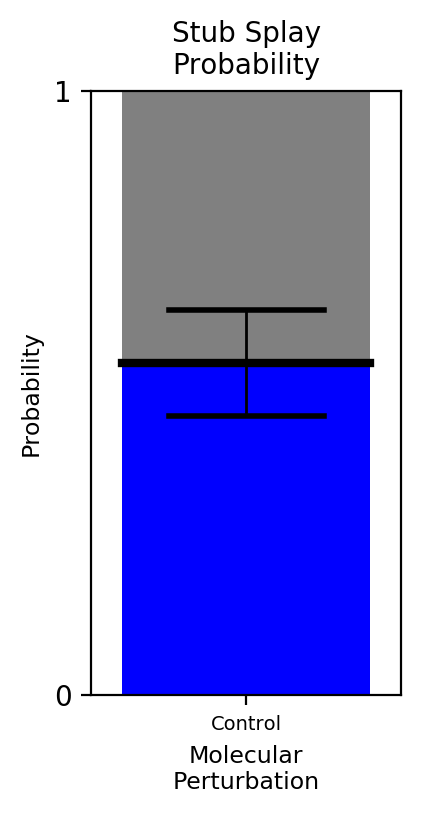

In [4]:
plt.figure(dpi=200, figsize=[2,4])
plt.bar([0], [WTyesNorm], color='blue')
plt.bar([0], [WTnoNorm], bottom=[WTyesNorm], color='gray')
plt.xticks([0], ['Control'], fontsize=7)
plt.yticks([0,1])
plt.title('Stub Splay\nProbability', fontsize=10)
plt.xlabel('Molecular\nPerturbation', fontsize=8.5)
plt.ylabel('Probability', fontsize=8.5)
plt.xlim(-0.5,0.5)
plt.ylim(0,1)
plt.plot([-0.4,0.4], [WTyesNorm, WTyesNorm], color='black', linewidth=3)
plt.plot([-0.25,0.25], [WTlow, WTlow], color='black', linewidth=2)
plt.plot([-0.25,0.25], [WThigh, WThigh], color='black', linewidth=2)
plt.plot([0,0], [WTlow, WThigh], [0,0], color='black', linewidth=1)
plt.savefig('1D.eps', format='eps', dpi=1000)
#plt.close()

68


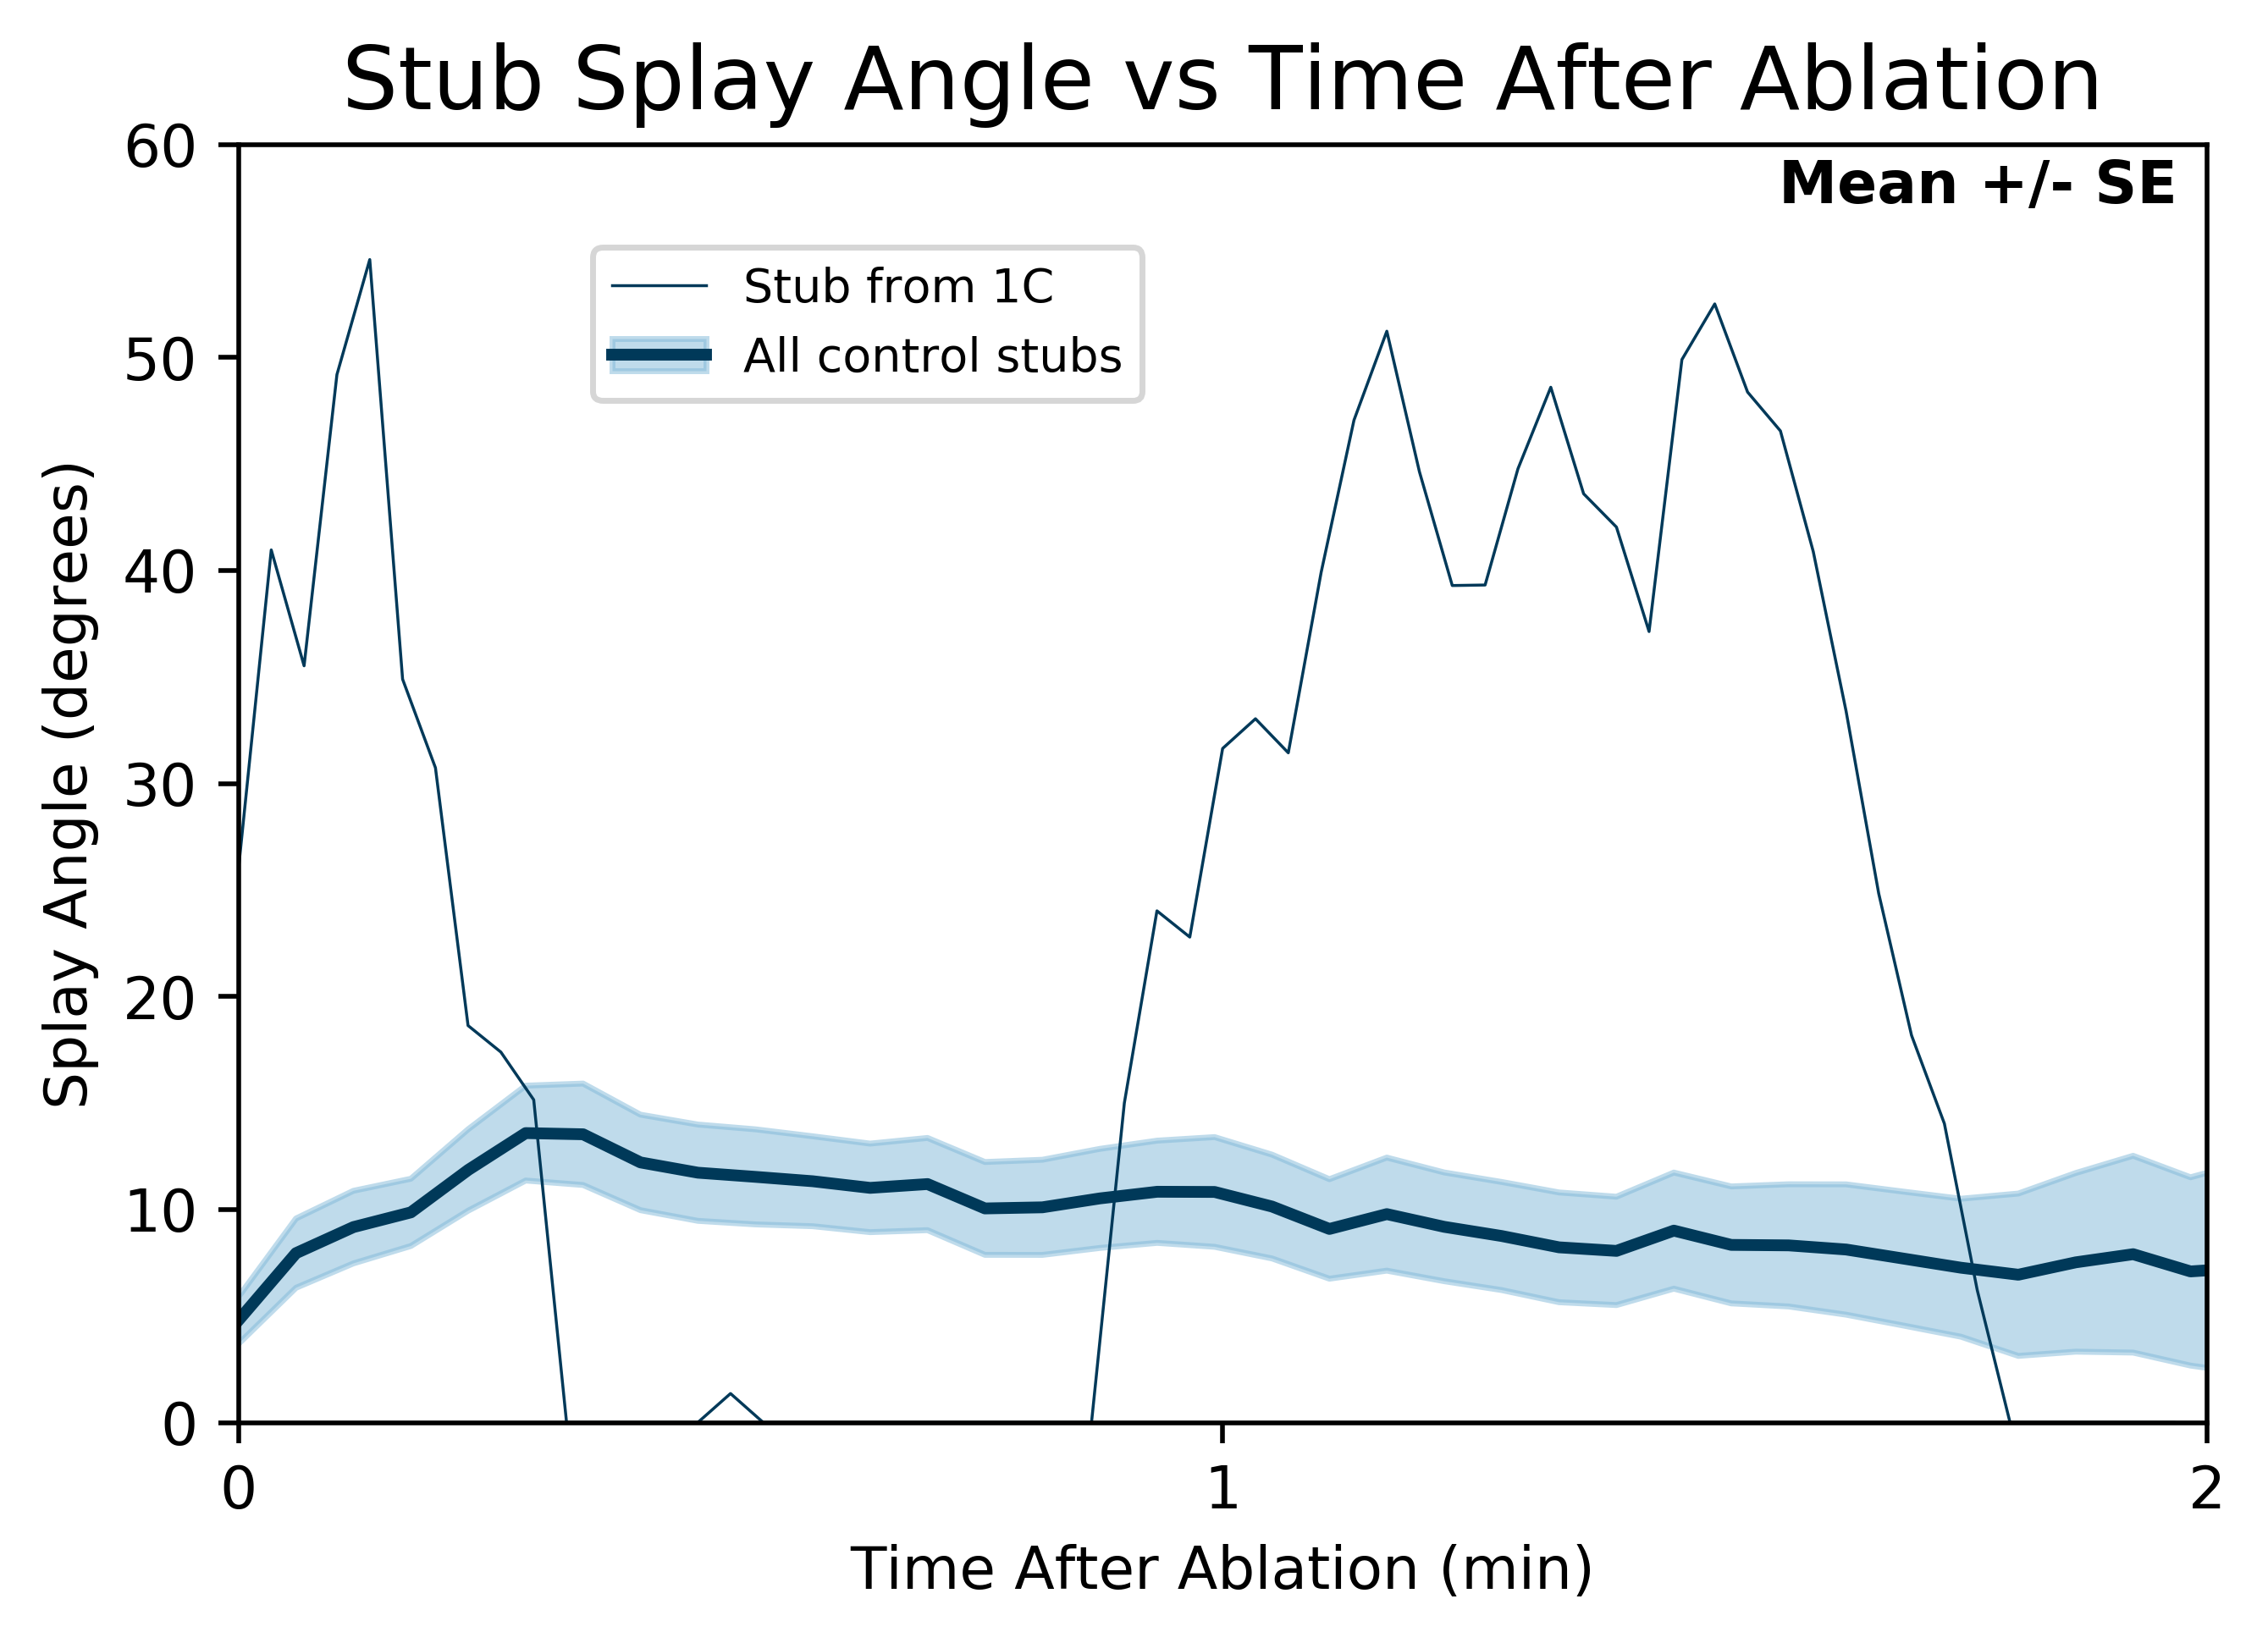

In [5]:
plt.figure(dpi=500)
line1, = plt.plot(WT0times[9], WT0angles[9], c=colors[0], linewidth=0.5)
line2, = plt.plot(t0TimesT[0], t0AnglesT[0], c=colors[0], linewidth=2)
plt.fill_between(t0TimesT[0], t0LowAngT[0], t0HighAngT[0], color=fillColors[0], alpha=0.5)
plt.title('Stub Splay Angle vs Time After Ablation', fontsize='15')
plt.xlabel('Time After Ablation (min)', fontsize='10')
plt.ylabel('Splay Angle (degrees)', fontsize='10')
plt.xlim(0,2)
plt.ylim(0,60)
plt.xticks([0,1,2])
plt.yticks([0,10,20,30,40,50,60])
patch = pchs.Patch(color=fillColors[0], alpha=0.5)
plt.legend((line1,(patch,line2)), ('Stub from 1C', 'All control stubs'), fontsize=8, loc=(0.18,0.8))
plt.text(1.97, 58, 'Mean +/- SE', color='black', fontweight='bold', fontsize=10, horizontalalignment='right', verticalalignment='center')
#plt.savefig('2C.eps', format='eps', dpi=1000)
#plt.close()

print(len(WT0angles))

37


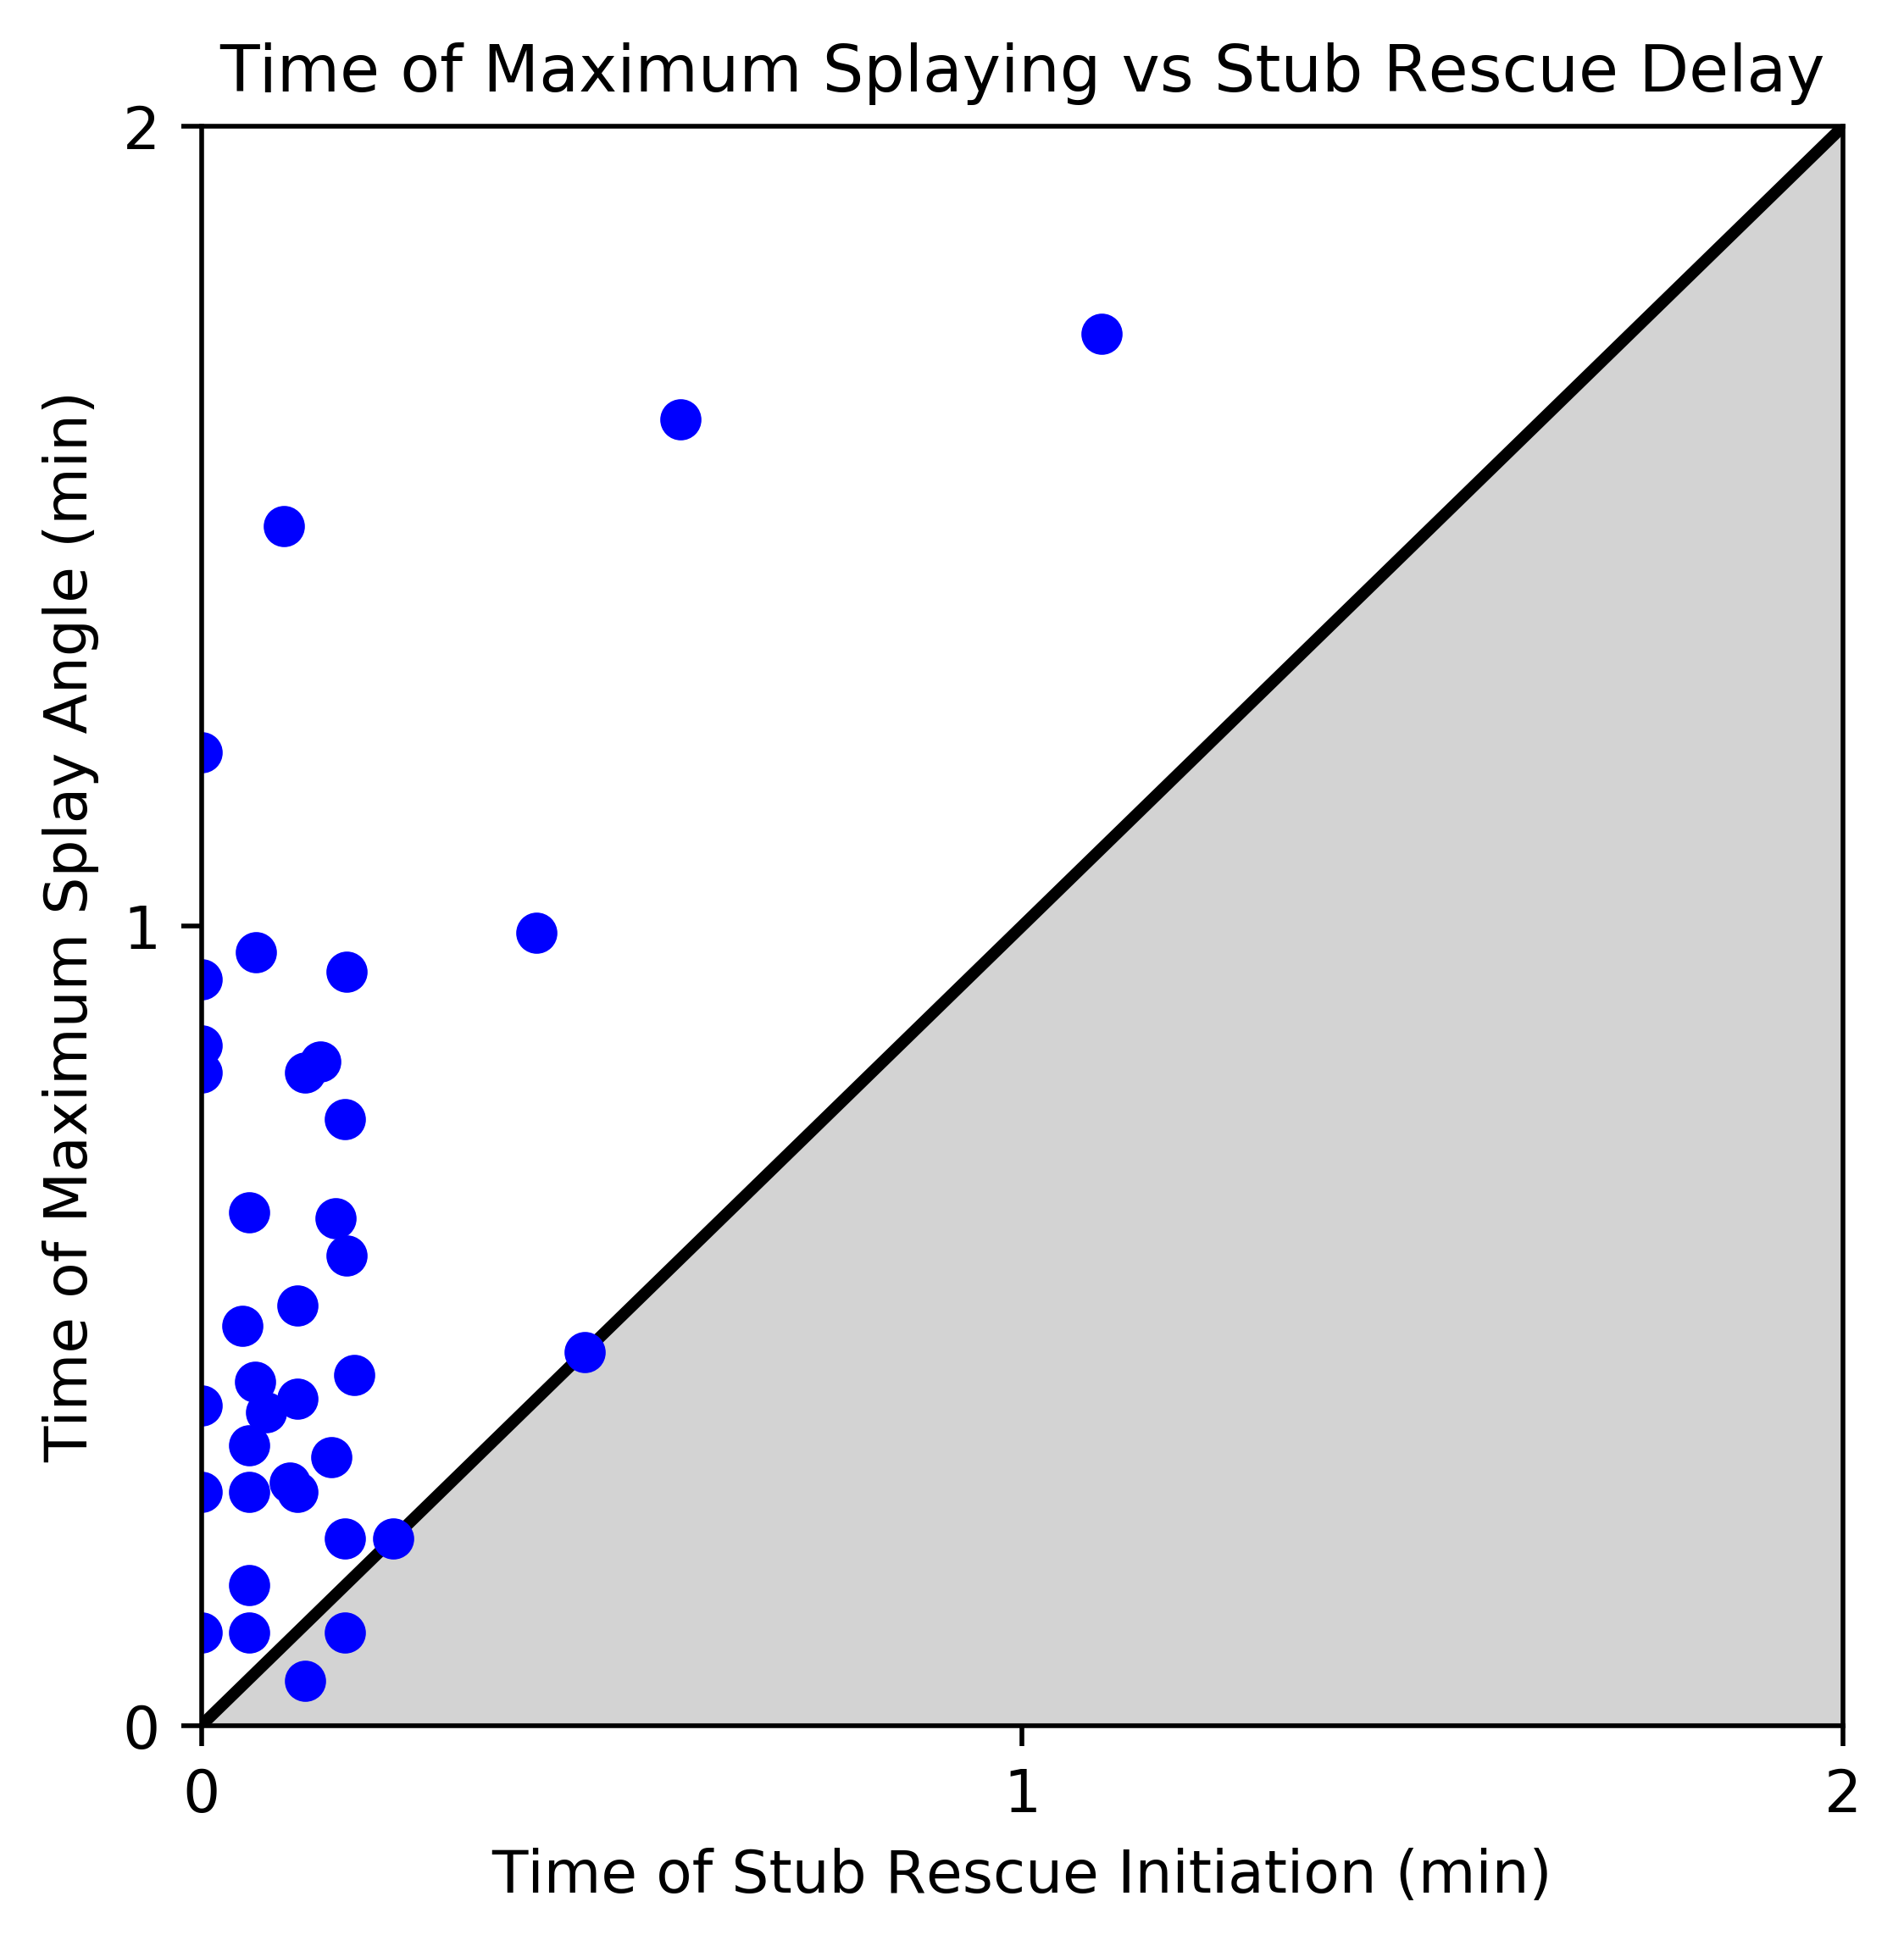

In [6]:
plt.figure(dpi=500, figsize=[5,5])
plt.plot([0,2], [0,2], color='black', linewidth=2, zorder=1)
plt.fill_between([0,2],[0,2],[0,0], color='lightgray', zorder=0)
plt.scatter(WTmaxTsR, WTmaxTsS, color='blue', zorder=2)
plt.xlim(0,2)
plt.ylim(0,2)
plt.xticks([0,1,2])
plt.yticks([0,1,2])
plt.title('Time of Maximum Splaying vs Stub Rescue Delay', fontsize=11)
plt.xlabel('Time of Stub Rescue Initiation (min)')
plt.ylabel('Time of Maximum Splay Angle (min)')
plt.savefig('2A.eps', format='eps', dpi=1000)
#plt.close()
print(len(WTmaxTsS))

3.065785940505023e-05
1635 505


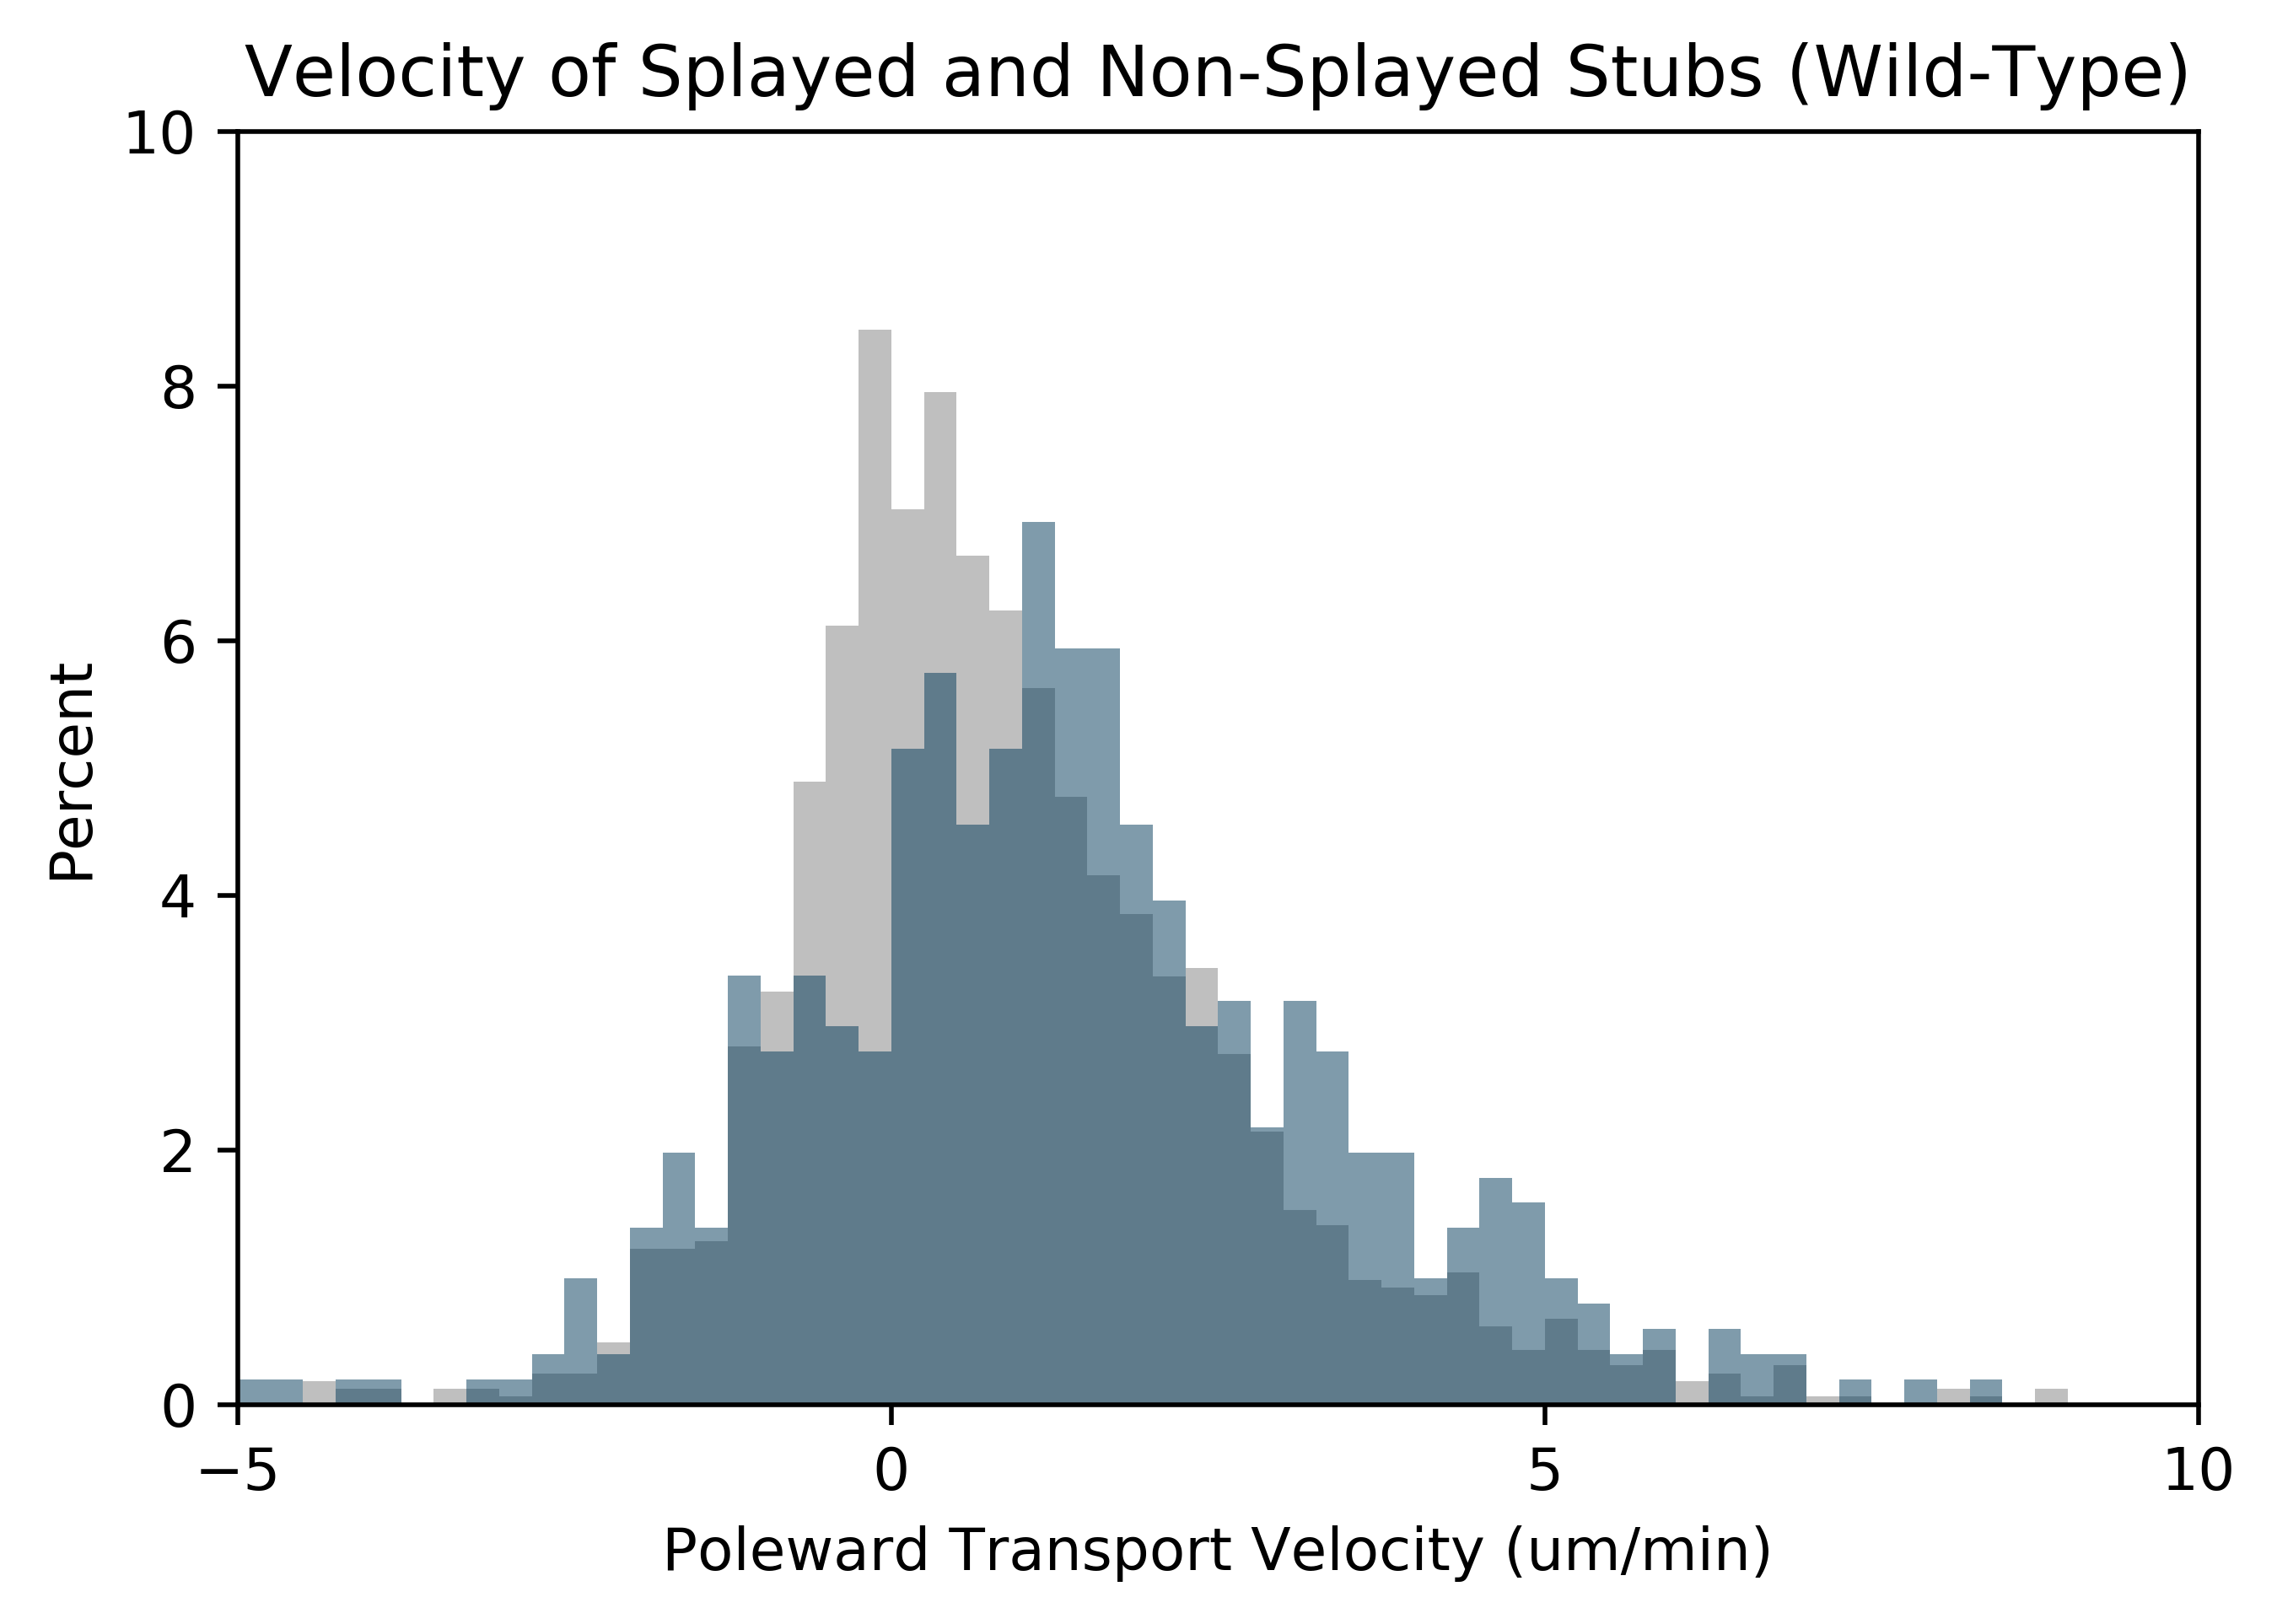

In [7]:
plt.figure(dpi=500)
plt.hist(WTvsNtF, 80, range=(-7.5,12.5), facecolor='gray', alpha=0.5, weights=WTweightsN)
plt.hist(WTvsYtF, 80, range=(-7.5,12.5), facecolor=colors[0], alpha=0.5, weights=WTweightsY)
plt.title('Velocity of Splayed and Non-Splayed Stubs (Wild-Type)')
plt.xlabel('Poleward Transport Velocity (um/min)')
plt.ylabel('Percent')
plt.xlim(-5,10)
plt.xticks([-5,0,5,10])
plt.ylim(0,0.1)
plt.yticks([0,0.02,0.04,0.06,0.08,0.1], [0,2,4,6,8,10])
plt.savefig('2B.eps', format='eps', dpi=1000)
#plt.close()
print(WTvsP)
print(len(WTvsNtF), len(WTvsYtF))

Text(0, 0.5, 'Groups')

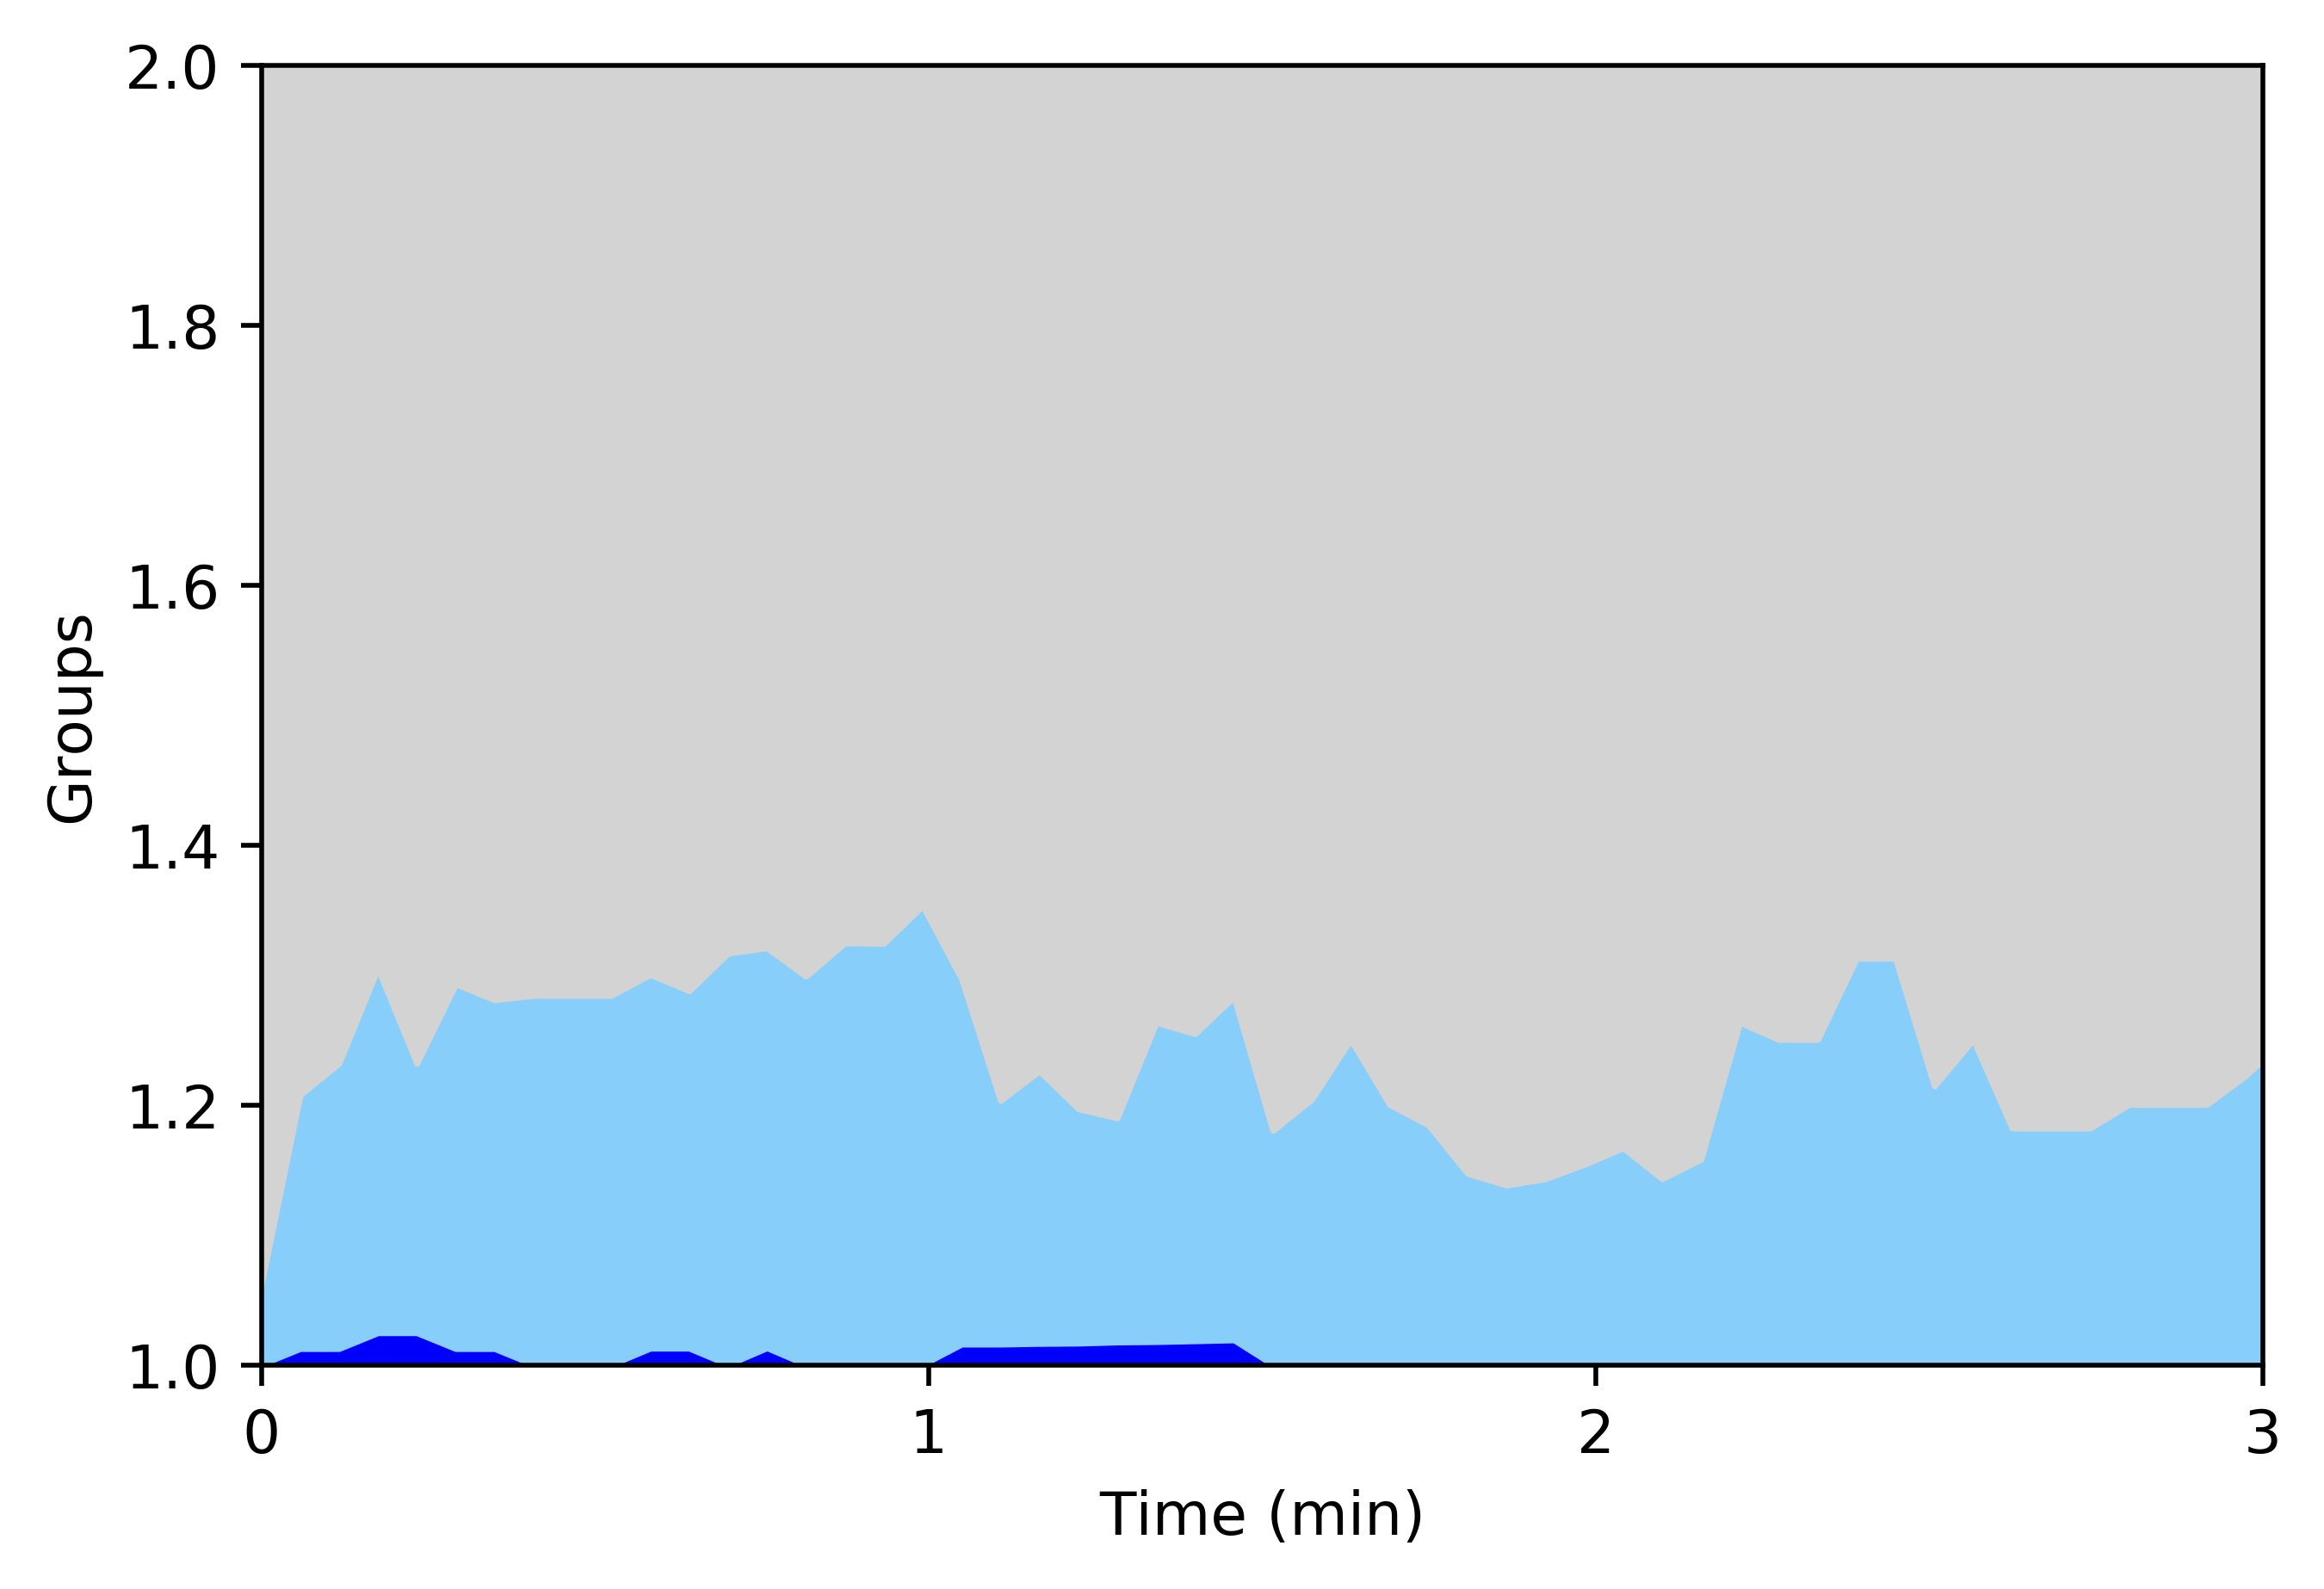

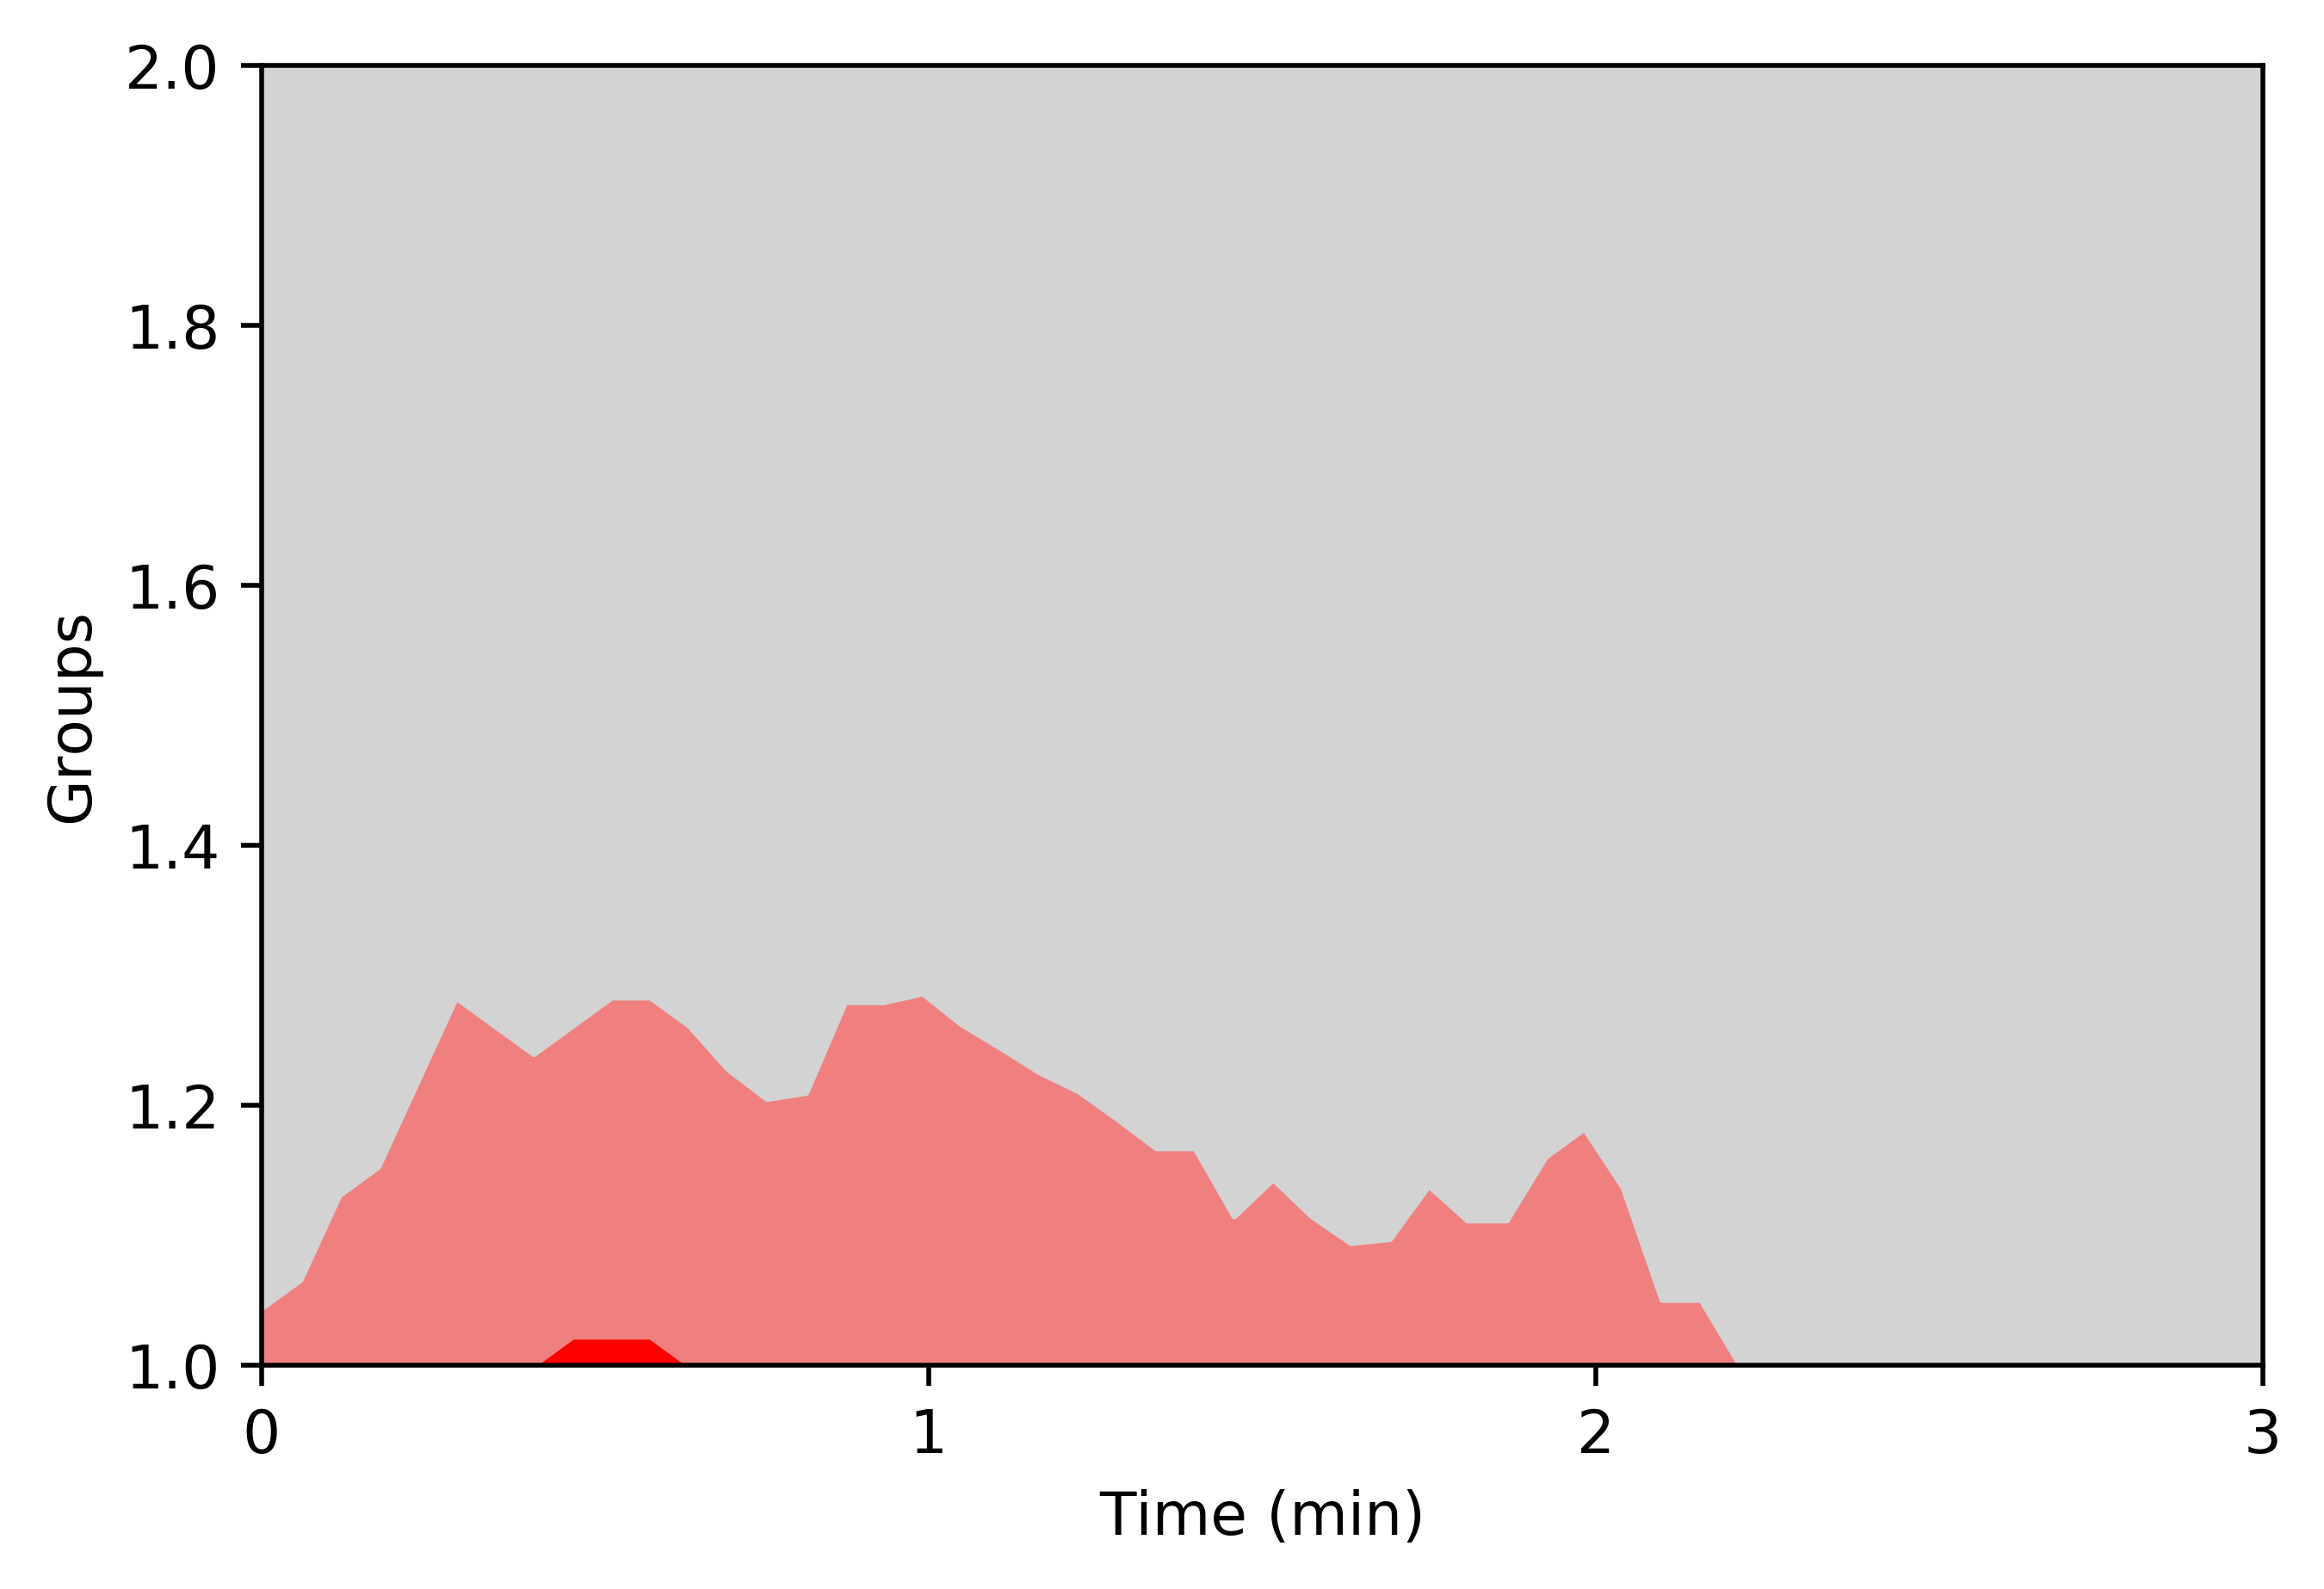

In [8]:
plt.figure(dpi=500)
plt.fill_between(tWTtimesG, 1, tWTgroupsG[1], color='blue')
plt.fill_between(tWTtimesG, tWTgroupsG[1], tWTgroupsG[0], color='lightskyblue')
plt.fill_between(tWTtimesG, tWTgroupsG[0], 2, color='lightgray')
plt.xlim(0,3)
plt.xticks([0,1,2,3])
plt.ylim(1,2)
plt.yticks([1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Time (min)', size=10)
plt.ylabel('Groups', size=10)
#plt.savefig('2D_3D-WT_noLeg.eps', format='eps', dpi=1000)
#plt.close()

plt.figure(dpi=500)
plt.fill_between(tNuMAtimesG, 1, tNuMAgroupsG[1], color='red')
plt.fill_between(tNuMAtimesG, tNuMAgroupsG[1], tNuMAgroupsG[0], color='lightcoral')
plt.fill_between(tNuMAtimesG, tNuMAgroupsG[0], 2, color='lightgray')
plt.xlim(0,3)
plt.xticks([0,1,2,3])
plt.ylim(1,2)
plt.yticks([1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Time (min)', size=10)
plt.ylabel('Groups', size=10)
#plt.savefig('3D-NuMA_noLeg.eps', format='eps', dpi=1000)
#plt.close()

68 21 35
37 12 13


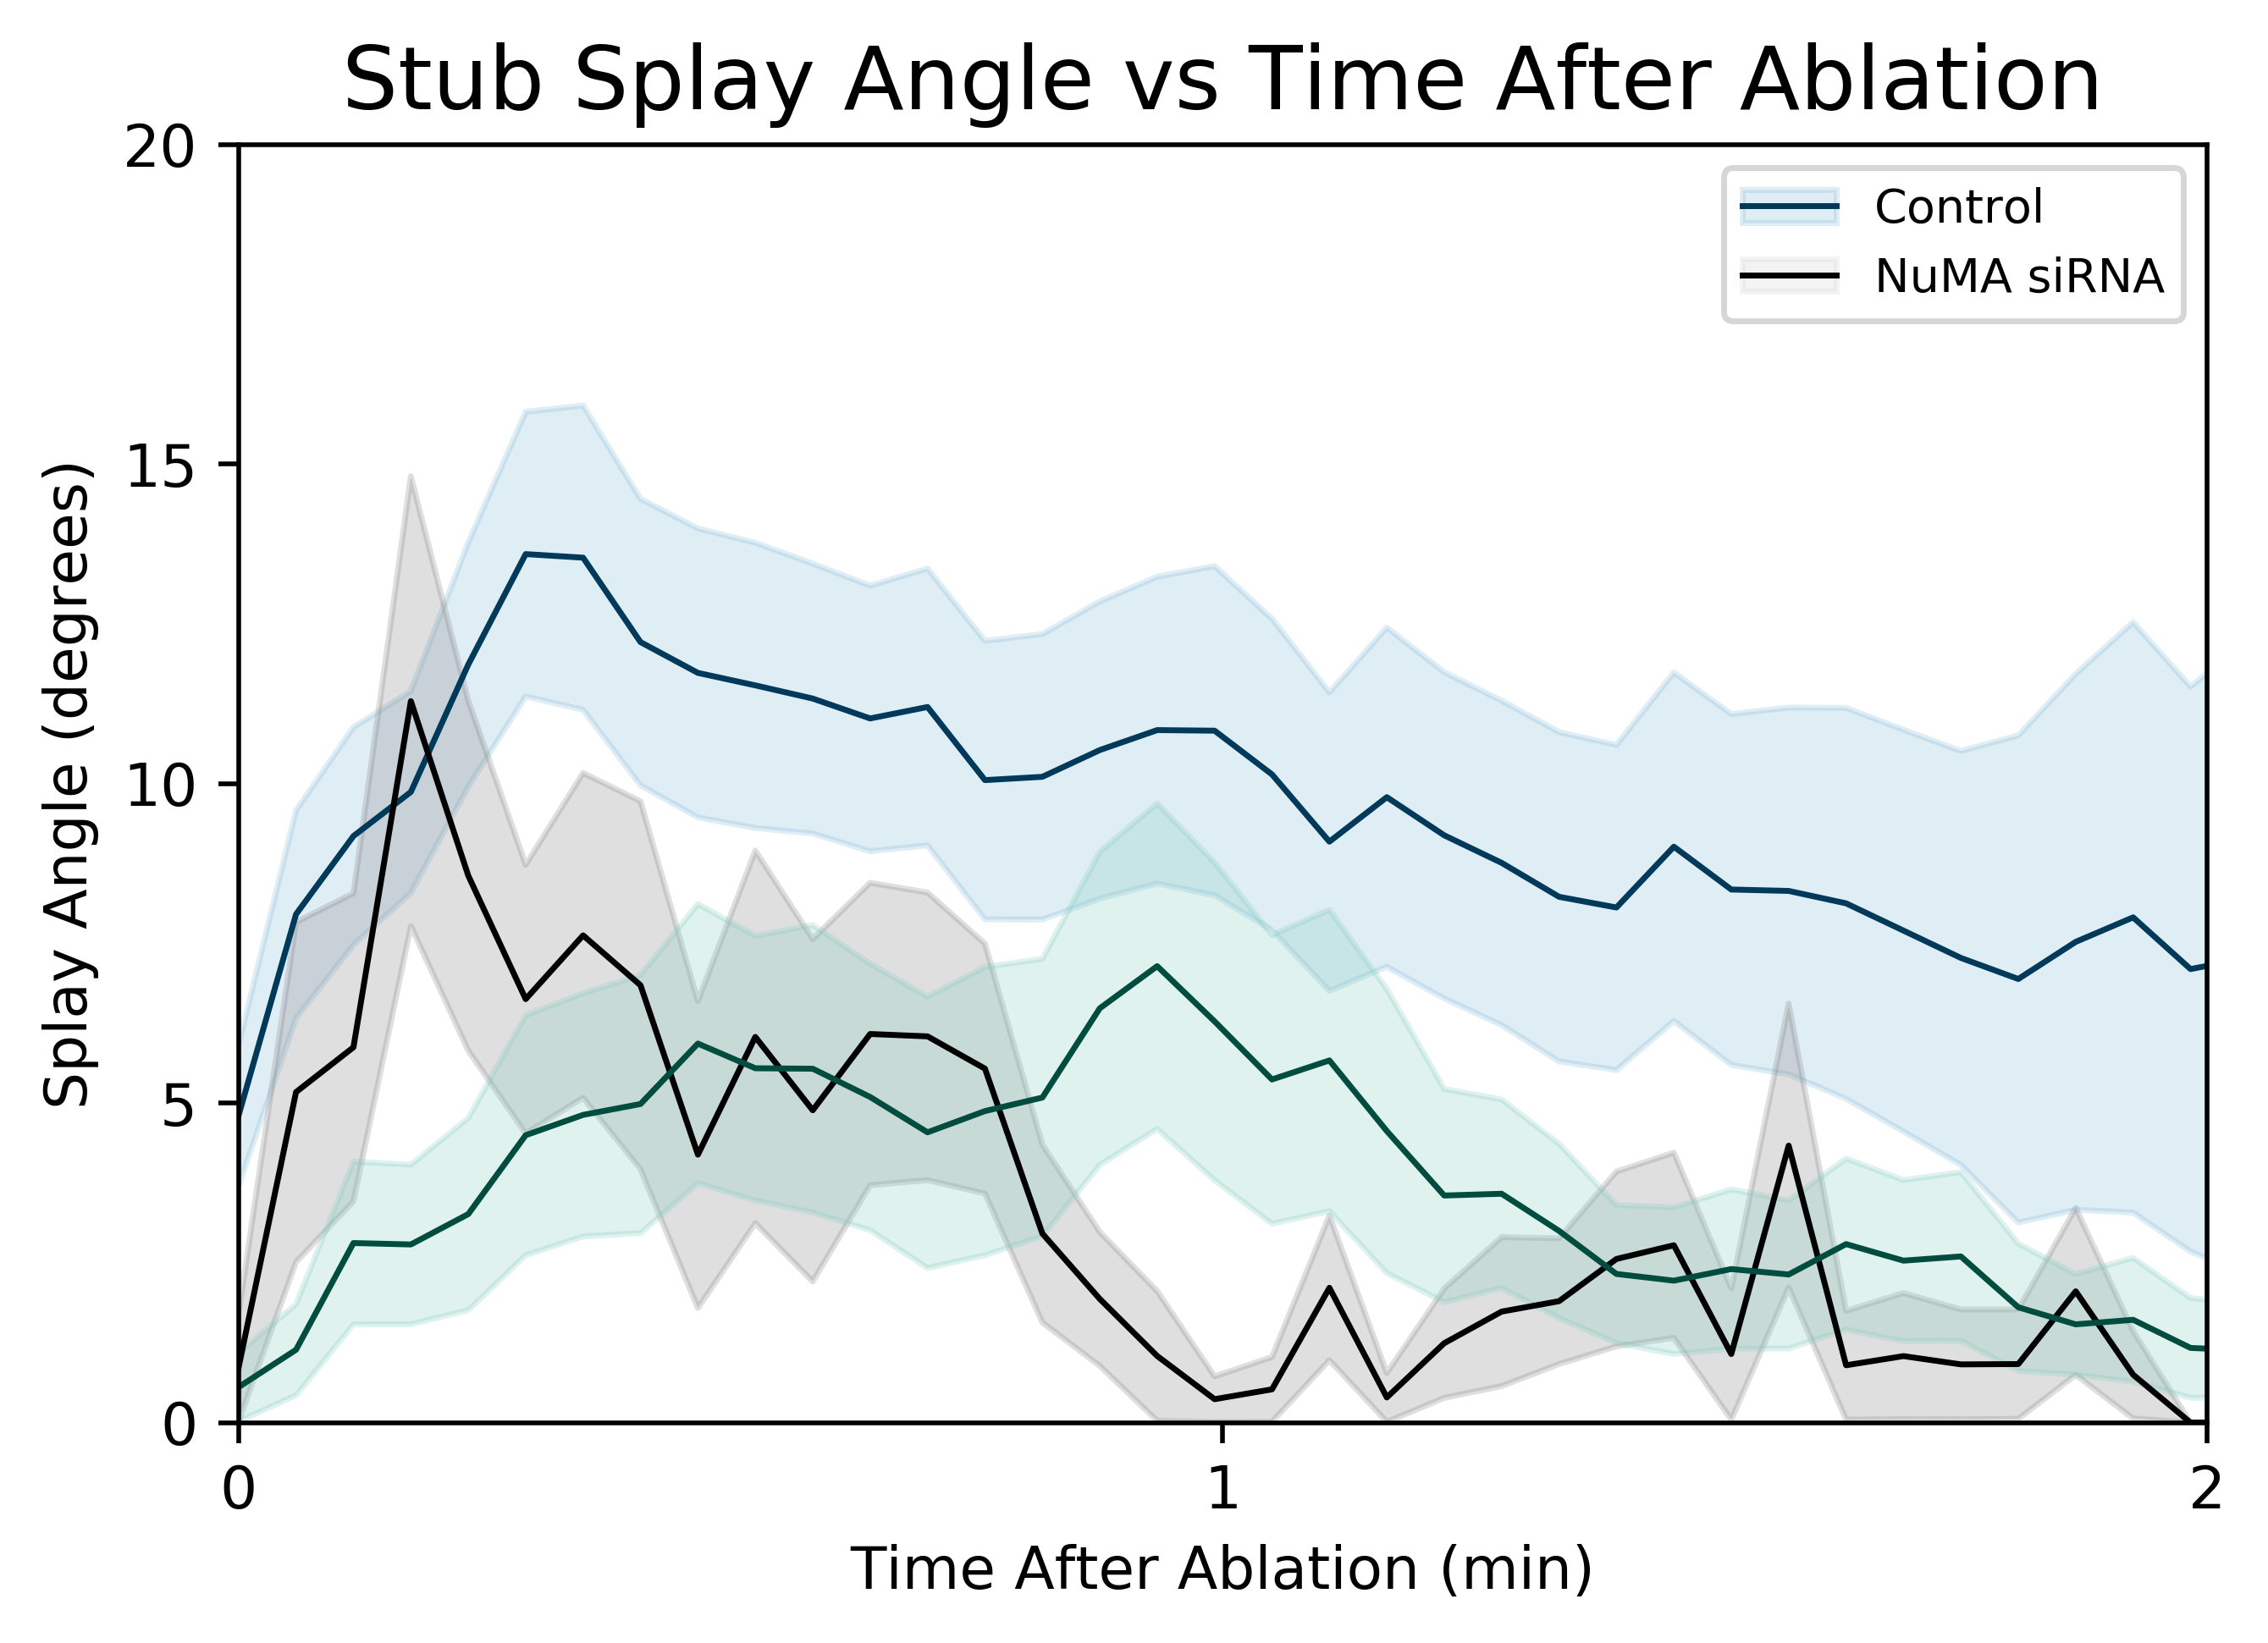

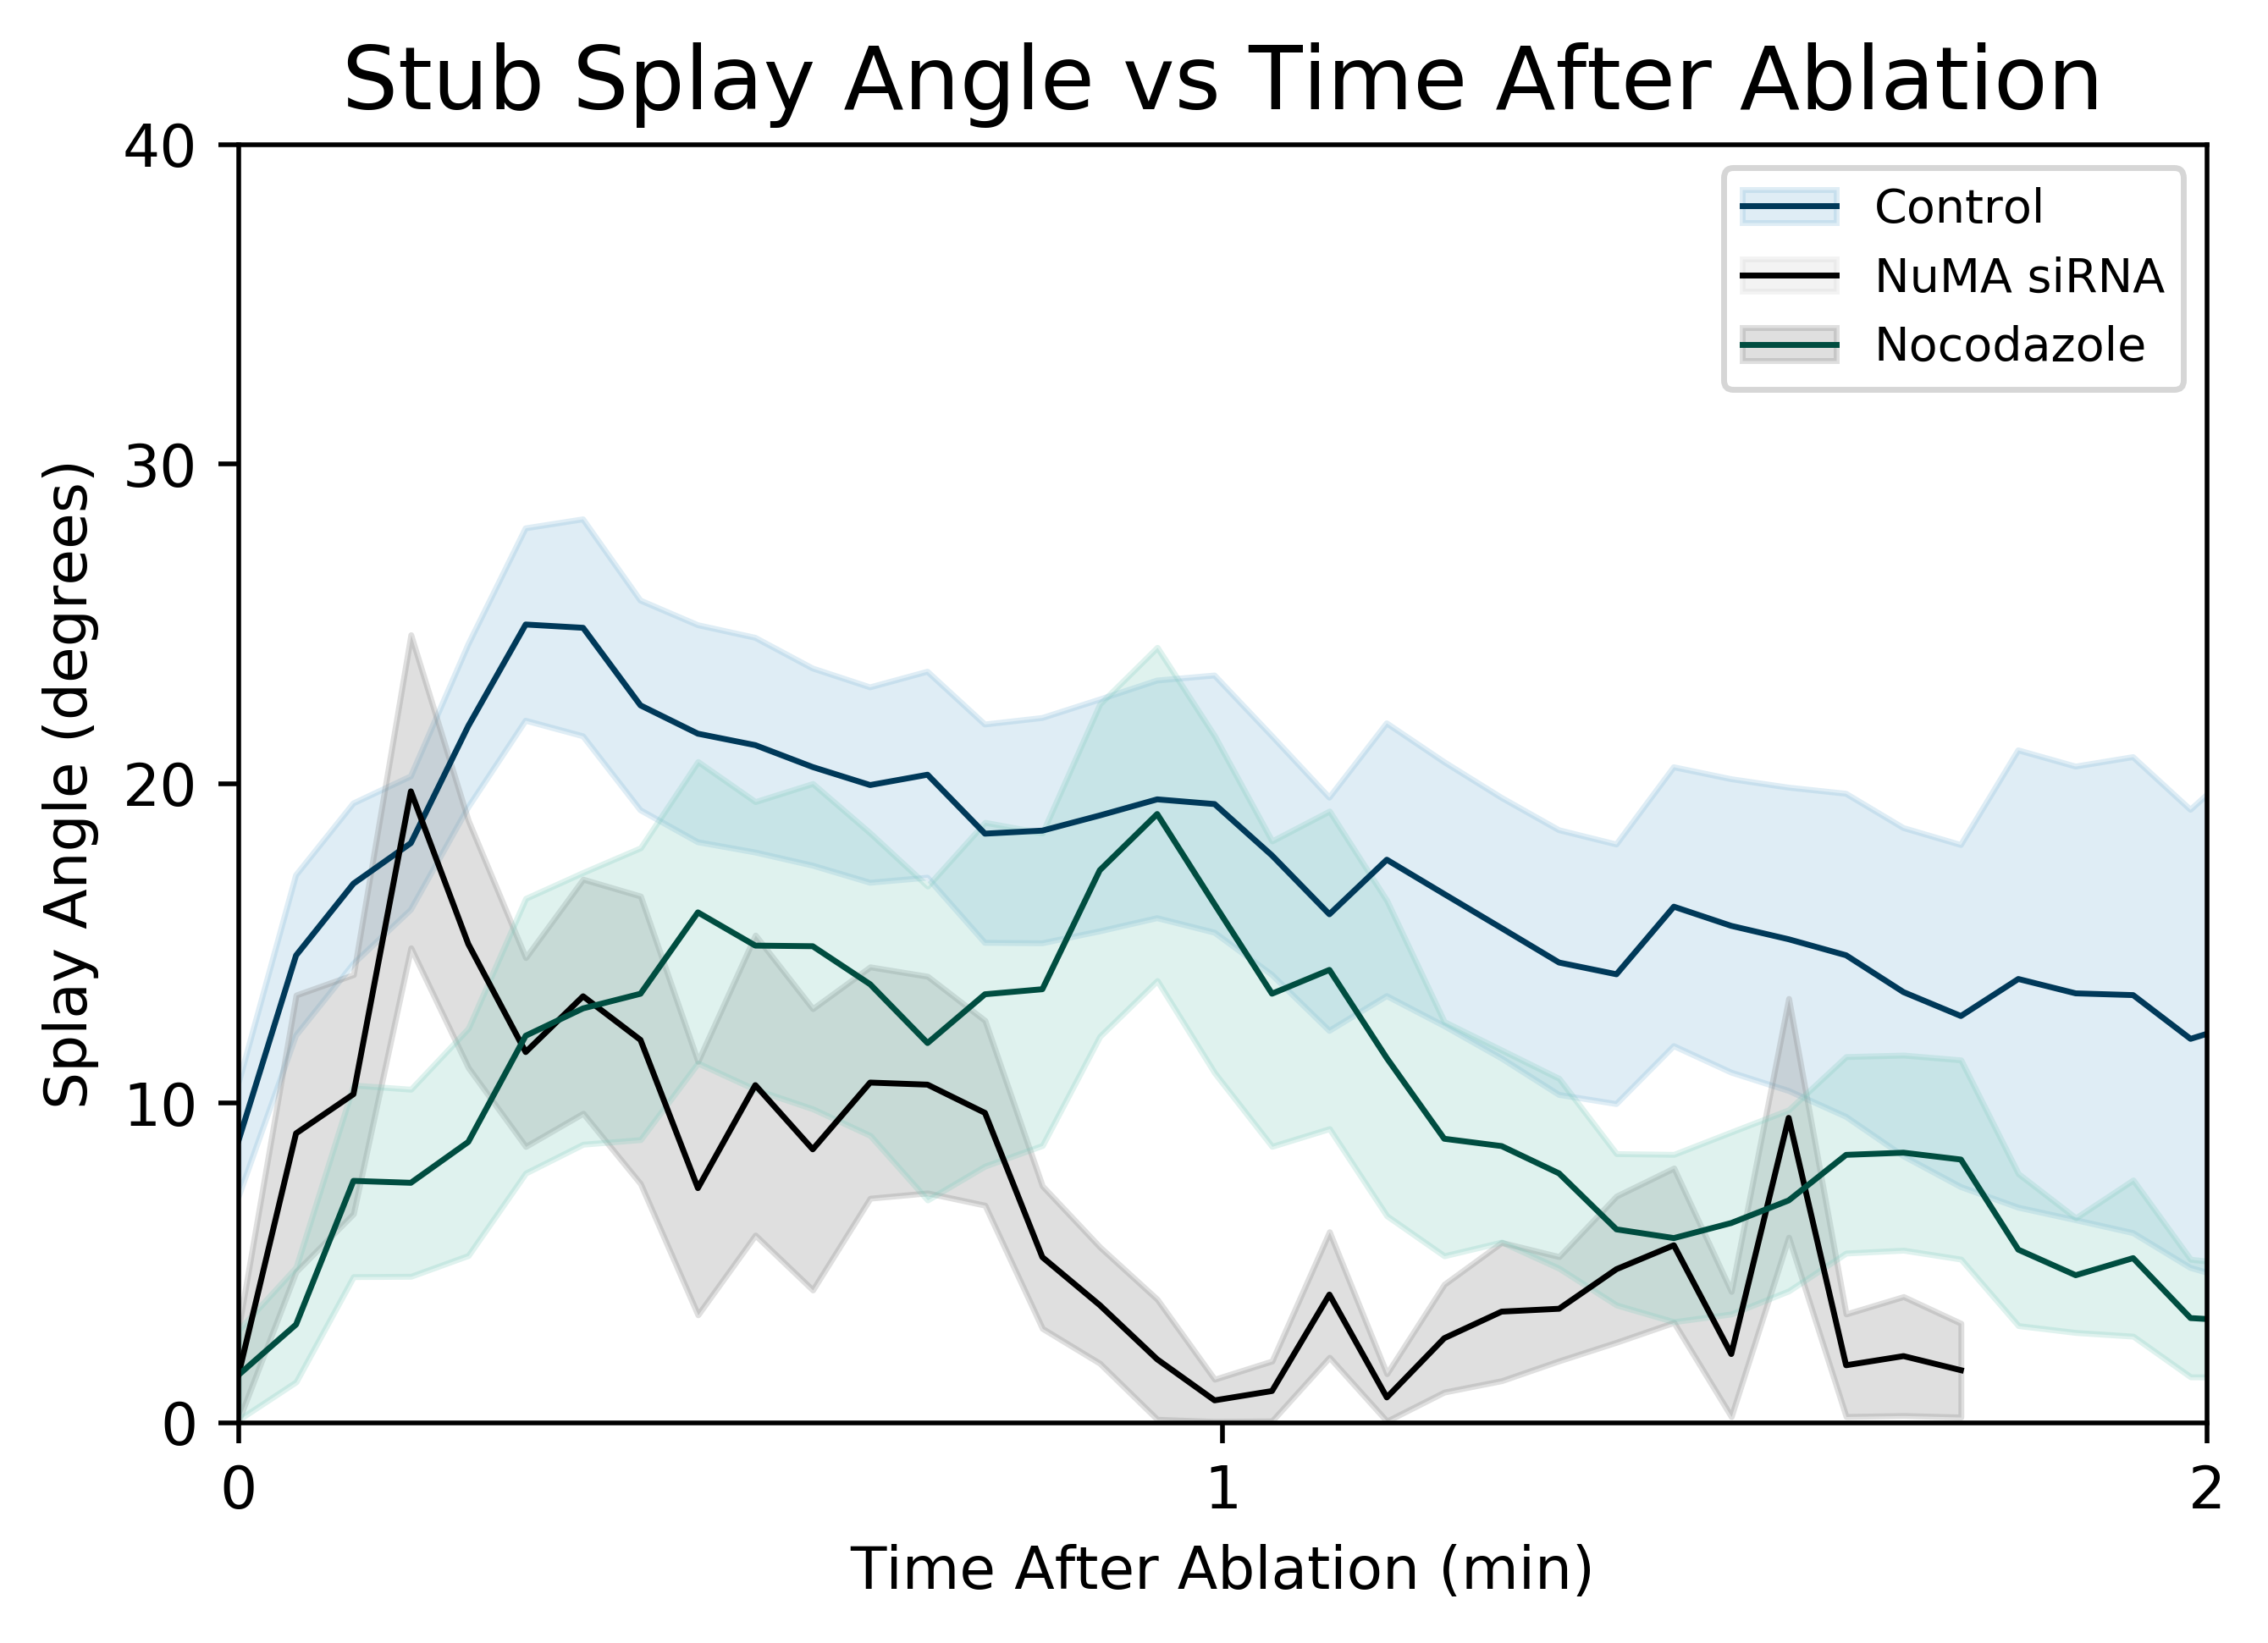

In [9]:
lines = []
patchWT = pchs.Patch(color=fillColors[0], alpha=0.25)
patchNDZ = pchs.Patch(color='lightgray', alpha=0.25)
patchNuMA = pchs.Patch(color=fillColors[1], alpha=0.25)
plt.figure(dpi=500)
lineWT, = plt.plot(t0Times[0], t0Angles[0], c=colors[0], linewidth=1)
plt.fill_between(t0Times[0], t0LowAng[0], t0HighAng[0], color=fillColors[0], alpha=0.25)
lineNDZ, = plt.plot(t0Times[1], t0Angles[1], c=colors[1], linewidth=1)
plt.fill_between(t0Times[1], t0LowAng[1], t0HighAng[1], color=fillColors[1], alpha=0.25)
lineNuMA, = plt.plot(t0Times[2], t0Angles[2], c=colors[2], linewidth=1)
plt.fill_between(t0Times[2], t0LowAng[2], t0HighAng[2], color=fillColors[2], alpha=0.25)
plt.title('Stub Splay Angle vs Time After Ablation', fontsize='15')
plt.xlabel('Time After Ablation (min)', fontsize='10')
plt.ylabel('Splay Angle (degrees)', fontsize='10')
plt.xlim(0,2)
plt.ylim(0,20)
plt.xticks([0,1,2])
plt.yticks([0,5,10,15,20])
plt.legend(((patchWT,lineWT),(patchNDZ,lineNDZ),(patchNuMA,lineNuMA)), ('Control', 'NuMA siRNA'), fontsize=8)
plt.savefig('2E.eps', format='eps', dpi=1000)
#plt.close()
print(len(angles0[0]), len(angles0[1]), len(angles0[2]))

lines = []
patchWT = pchs.Patch(color=fillColors[0], alpha=0.25)
patchNDZ = pchs.Patch(color='lightgray', alpha=0.25)
patchNuMA = pchs.Patch(color=fillColors[1], alpha=0.25)
plt.figure(dpi=500)
lineWT, = plt.plot(tTimesT[0], tAnglesT[0], c=colors[0], linewidth=1)
plt.fill_between(tTimesT[0], tLowAngT[0], tHighAngT[0], color=fillColors[0], alpha=0.25)
lineNDZ, = plt.plot(tTimesT[1], tAnglesT[1], c=colors[1], linewidth=1)
plt.fill_between(tTimesT[1], tLowAngT[1], tHighAngT[1], color=fillColors[1], alpha=0.25)
lineNuMA, = plt.plot(tTimesT[2], tAnglesT[2], c=colors[2], linewidth=1)
plt.fill_between(tTimesT[2], tLowAngT[2], tHighAngT[2], color=fillColors[2], alpha=0.25)
plt.title('Stub Splay Angle vs Time After Ablation', fontsize='15')
plt.xlabel('Time After Ablation (min)', fontsize='10')
plt.ylabel('Splay Angle (degrees)', fontsize='10')
plt.xlim(0,2)
plt.ylim(0,40)
plt.xticks([0,1,2])
plt.yticks([0,10,20,30,40])
plt.legend(((patchWT,lineWT),(patchNDZ,lineNDZ),(patchNuMA,lineNuMA)), ('Control', 'NuMA siRNA', 'Nocodazole'), fontsize=8)
plt.savefig('S1B.eps', format='eps', dpi=1000)
#plt.close()
print(len(angles[0]), len(angles[1]), len(angles[2]))

[0.6666749579999207, 0.013552669829113443]
[0.9847735425966547, 0.0018417418055452369]


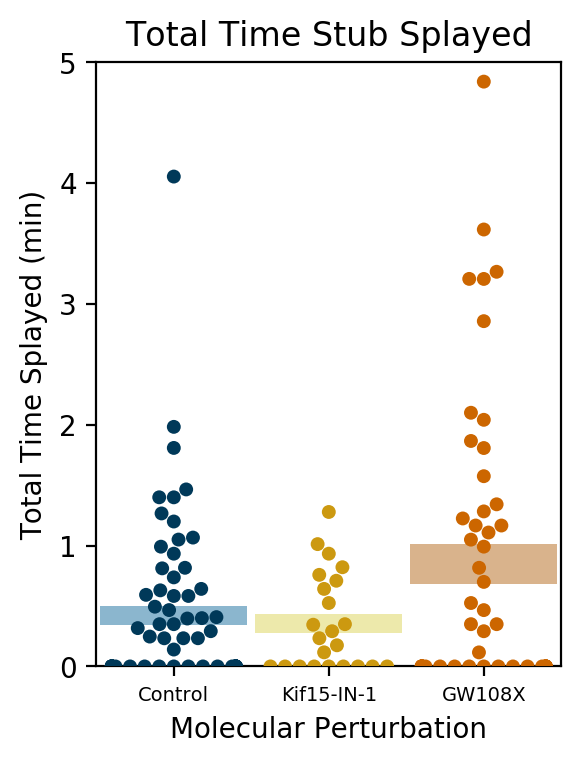

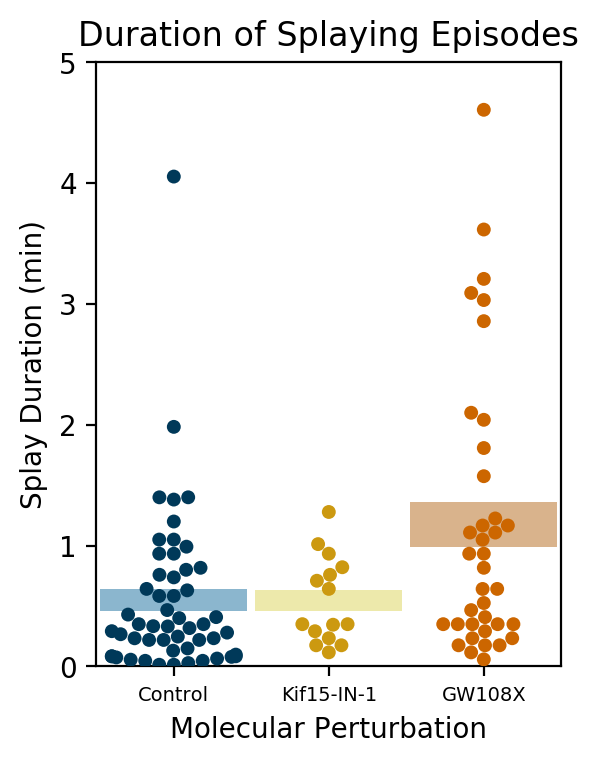

In [10]:
plt.figure(dpi=200, figsize=[3,4])
sb.swarmplot(x=swarmTypesTK, y=swarmTsTK, palette=colorsK)
sb.boxplot(x=tBoxTypesK, y=tEBoxK, palette=fillColorsK, width=0.95, fliersize=0, linewidth=0)
plt.title('Total Time Stub Splayed')
plt.xlabel('Molecular Perturbation')
plt.xticks(xsK, namesK, fontsize=7)
plt.ylabel('Total Time Splayed (min)')
plt.ylim(0,5)
plt.yticks([0,1,2,3,4,5])
plt.savefig('3C.eps', format='eps', dpi=1000)
#plt.close()
print(tPsK)


plt.figure(dpi=200, figsize=[3,4])
sb.swarmplot(x=swarmTypesEK, y=swarmTsEK, palette=colorsK)
sb.boxplot(x=eBoxTypesK, y=eEBoxK, palette=fillColorsK, width=0.95, fliersize=0, linewidth=0)
plt.title('Duration of Splaying Episodes')
plt.xlabel('Molecular Perturbation')
plt.xticks(xsK, namesK, fontsize=7)
plt.ylabel('Splay Duration (min)')
plt.ylim(0,5)
plt.yticks([0,1,2,3,4,5])
plt.savefig('S1E.eps', format='eps', dpi=1000)
#plt.close()
print(ePsK)

81 68
29 21
32 35
22 27
25 23
61 51


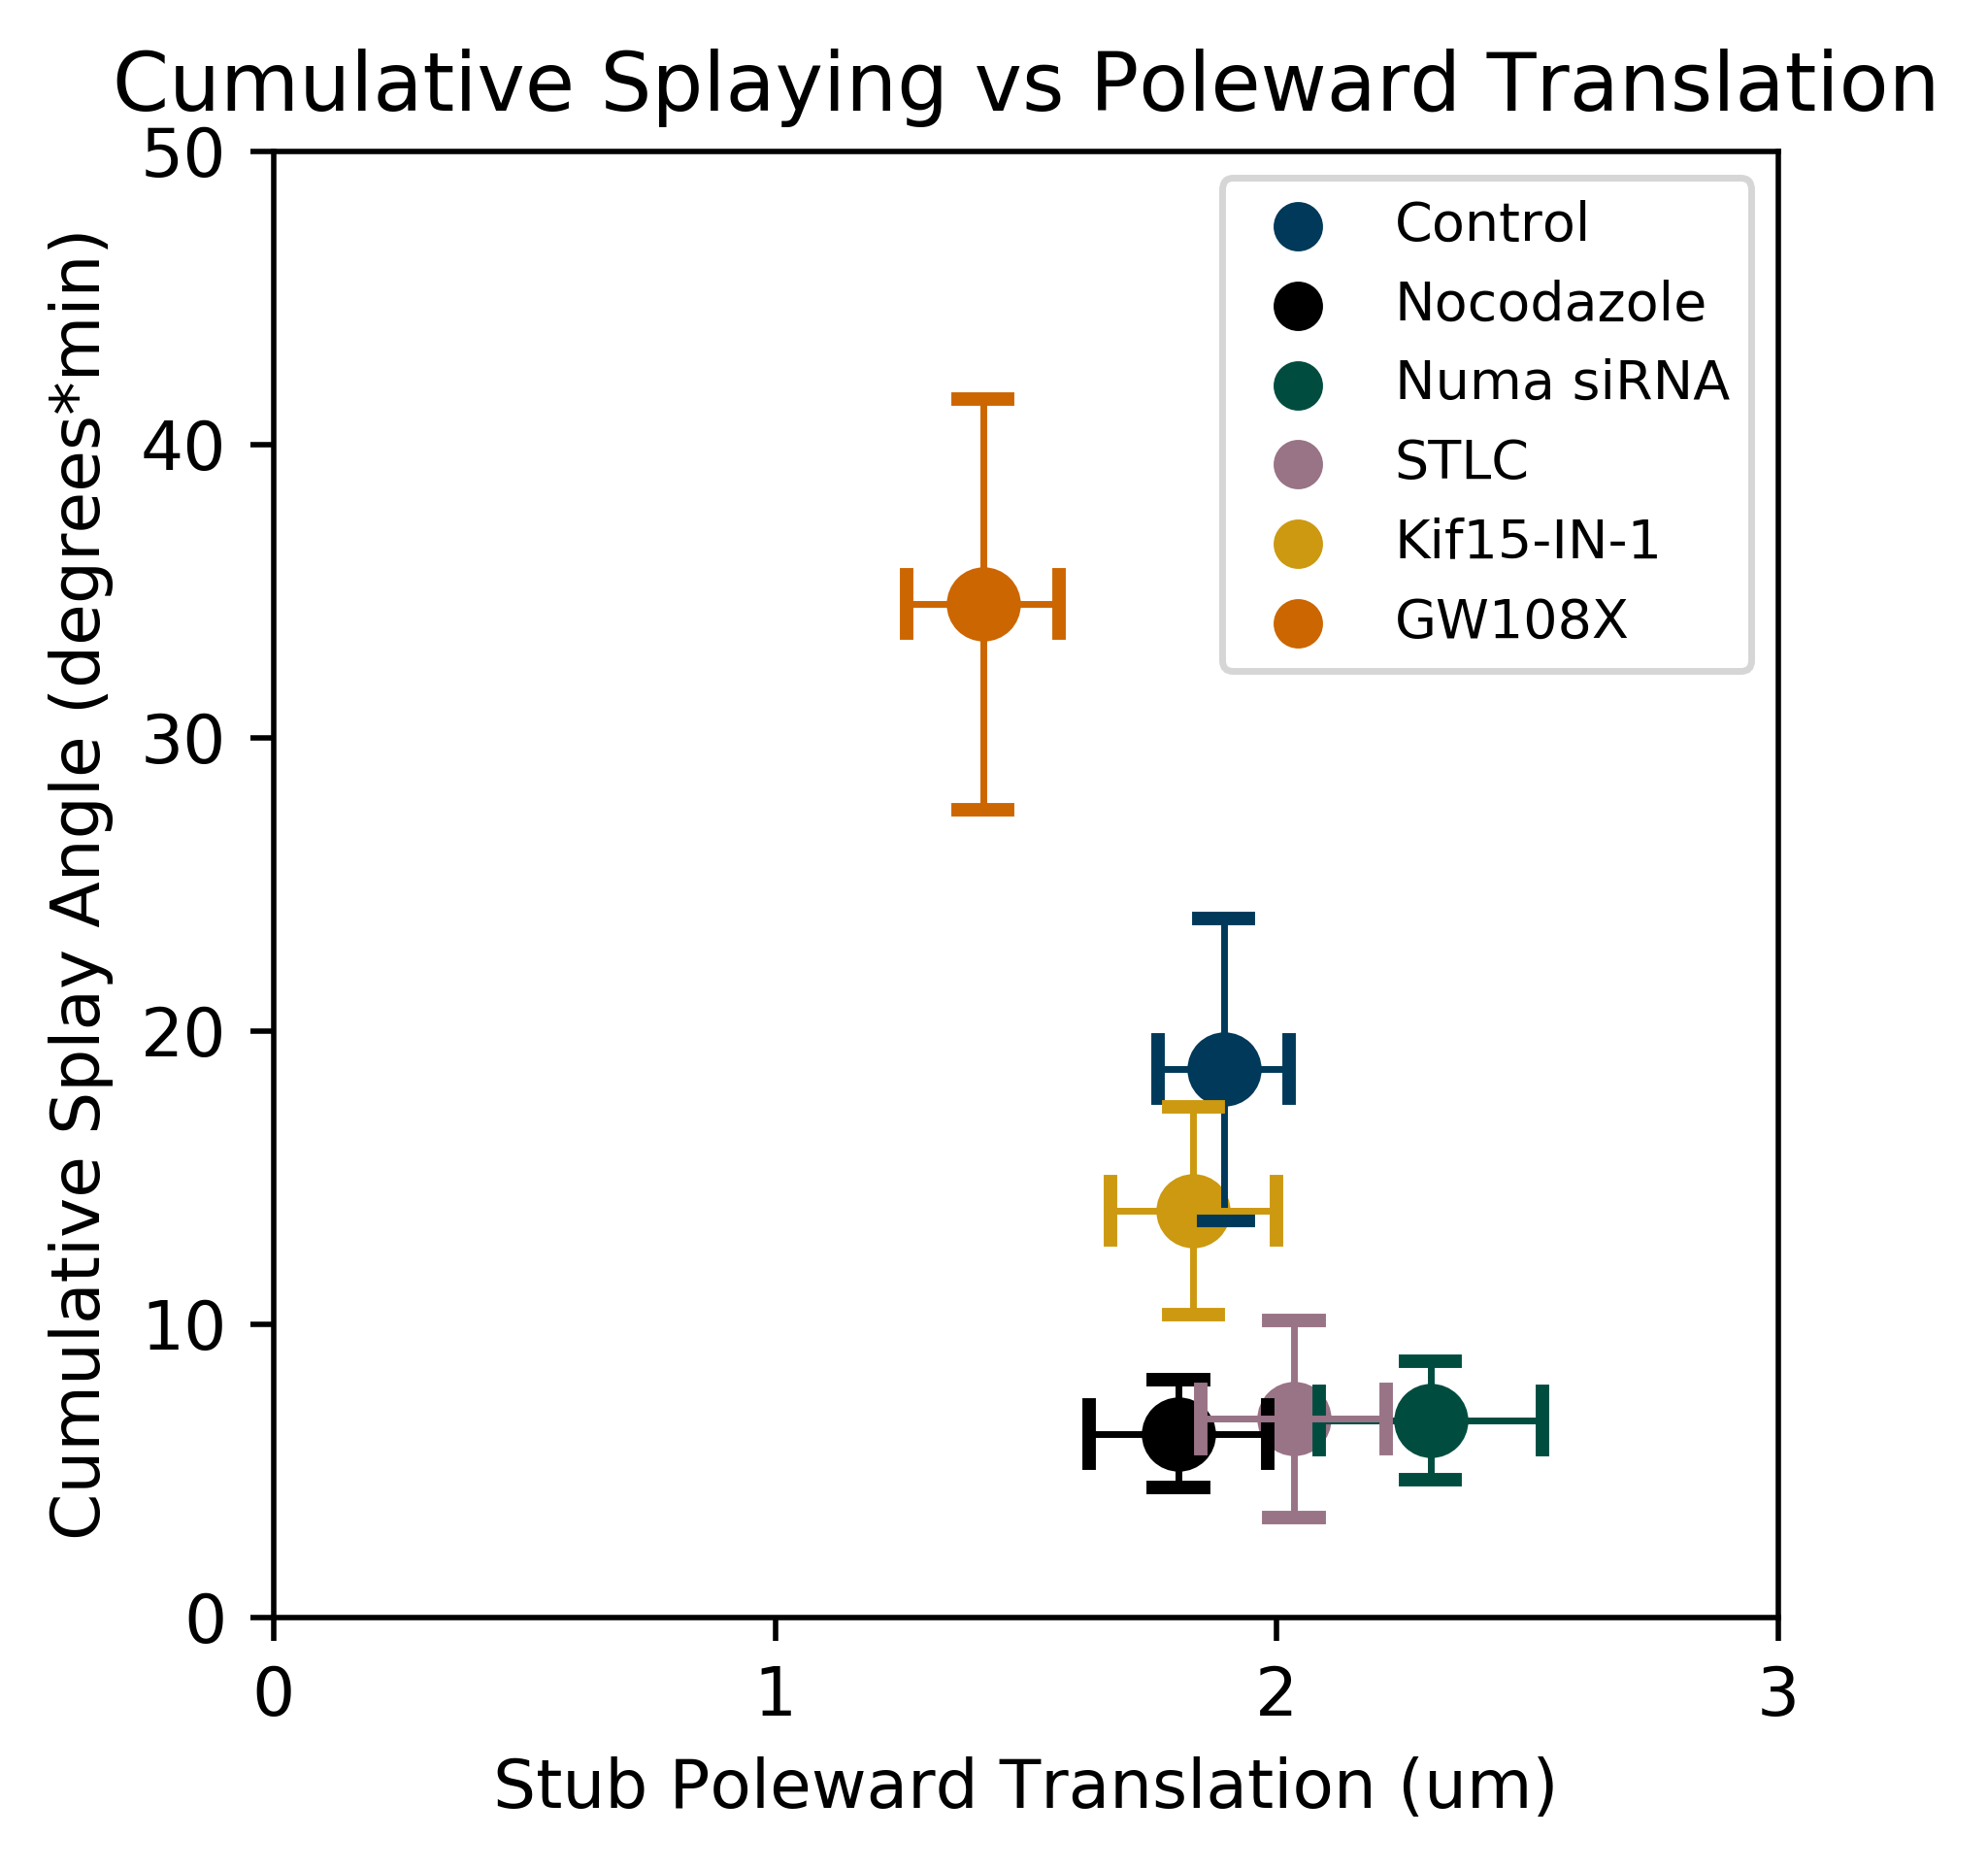

In [11]:
hands = []
plt.figure(dpi=500, figsize=[4,4])
for i in range(6):
    hands.append(plt.scatter(avgDs[i], aAvgInts[i], color=colors[i], s=40))
    plt.scatter(avgDs[i], aAvgInts[i], color=colors[i], s=100)
    plt.plot([lowDs[i], highDs[i]], [aAvgInts[i], aAvgInts[i]], color=colors[i], lw=1)
    plt.plot([avgDs[i], avgDs[i]], [aLowInts[i], aHighInts[i]], color=colors[i], lw=1)
    plt.plot([lowDs[i], lowDs[i]], [aAvgInts[i]-1, aAvgInts[i]+1], color=colors[i], lw=2)
    plt.plot([highDs[i], highDs[i]], [aAvgInts[i]-1, aAvgInts[i]+1], color=colors[i], lw=2)
    plt.plot([avgDs[i]-0.05, avgDs[i]+0.05], [aLowInts[i], aLowInts[i]], color=colors[i], lw=2)
    plt.plot([avgDs[i]-0.05, avgDs[i]+0.05], [aHighInts[i], aHighInts[i]], color=colors[i], lw=2)
plt.xlim(0,3)
plt.xticks([0,1,2,3])
plt.ylim(0,50)
plt.yticks([0,10,20,30,40,50])
plt.title('Cumulative Splaying vs Poleward Translation')
plt.xlabel('Stub Poleward Translation (um)')
plt.ylabel('Cumulative Splay Angle (degrees*min)')
plt.legend(hands, names, fontsize=8)
plt.savefig('3E.eps', format='eps', dpi=1000)
#plt.close()
for i in range(6):
    print(len(dckds[i]), len(angles010[i]))

C:\Apps\Anaconda3\lib\site-packages\matplotlib\legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "
C:\Apps\Anaconda3\lib\site-packages\matplotlib\legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "
C:\Apps\Anaconda3\lib\site-packages\matplotlib\legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


68 21 35
68 23 51


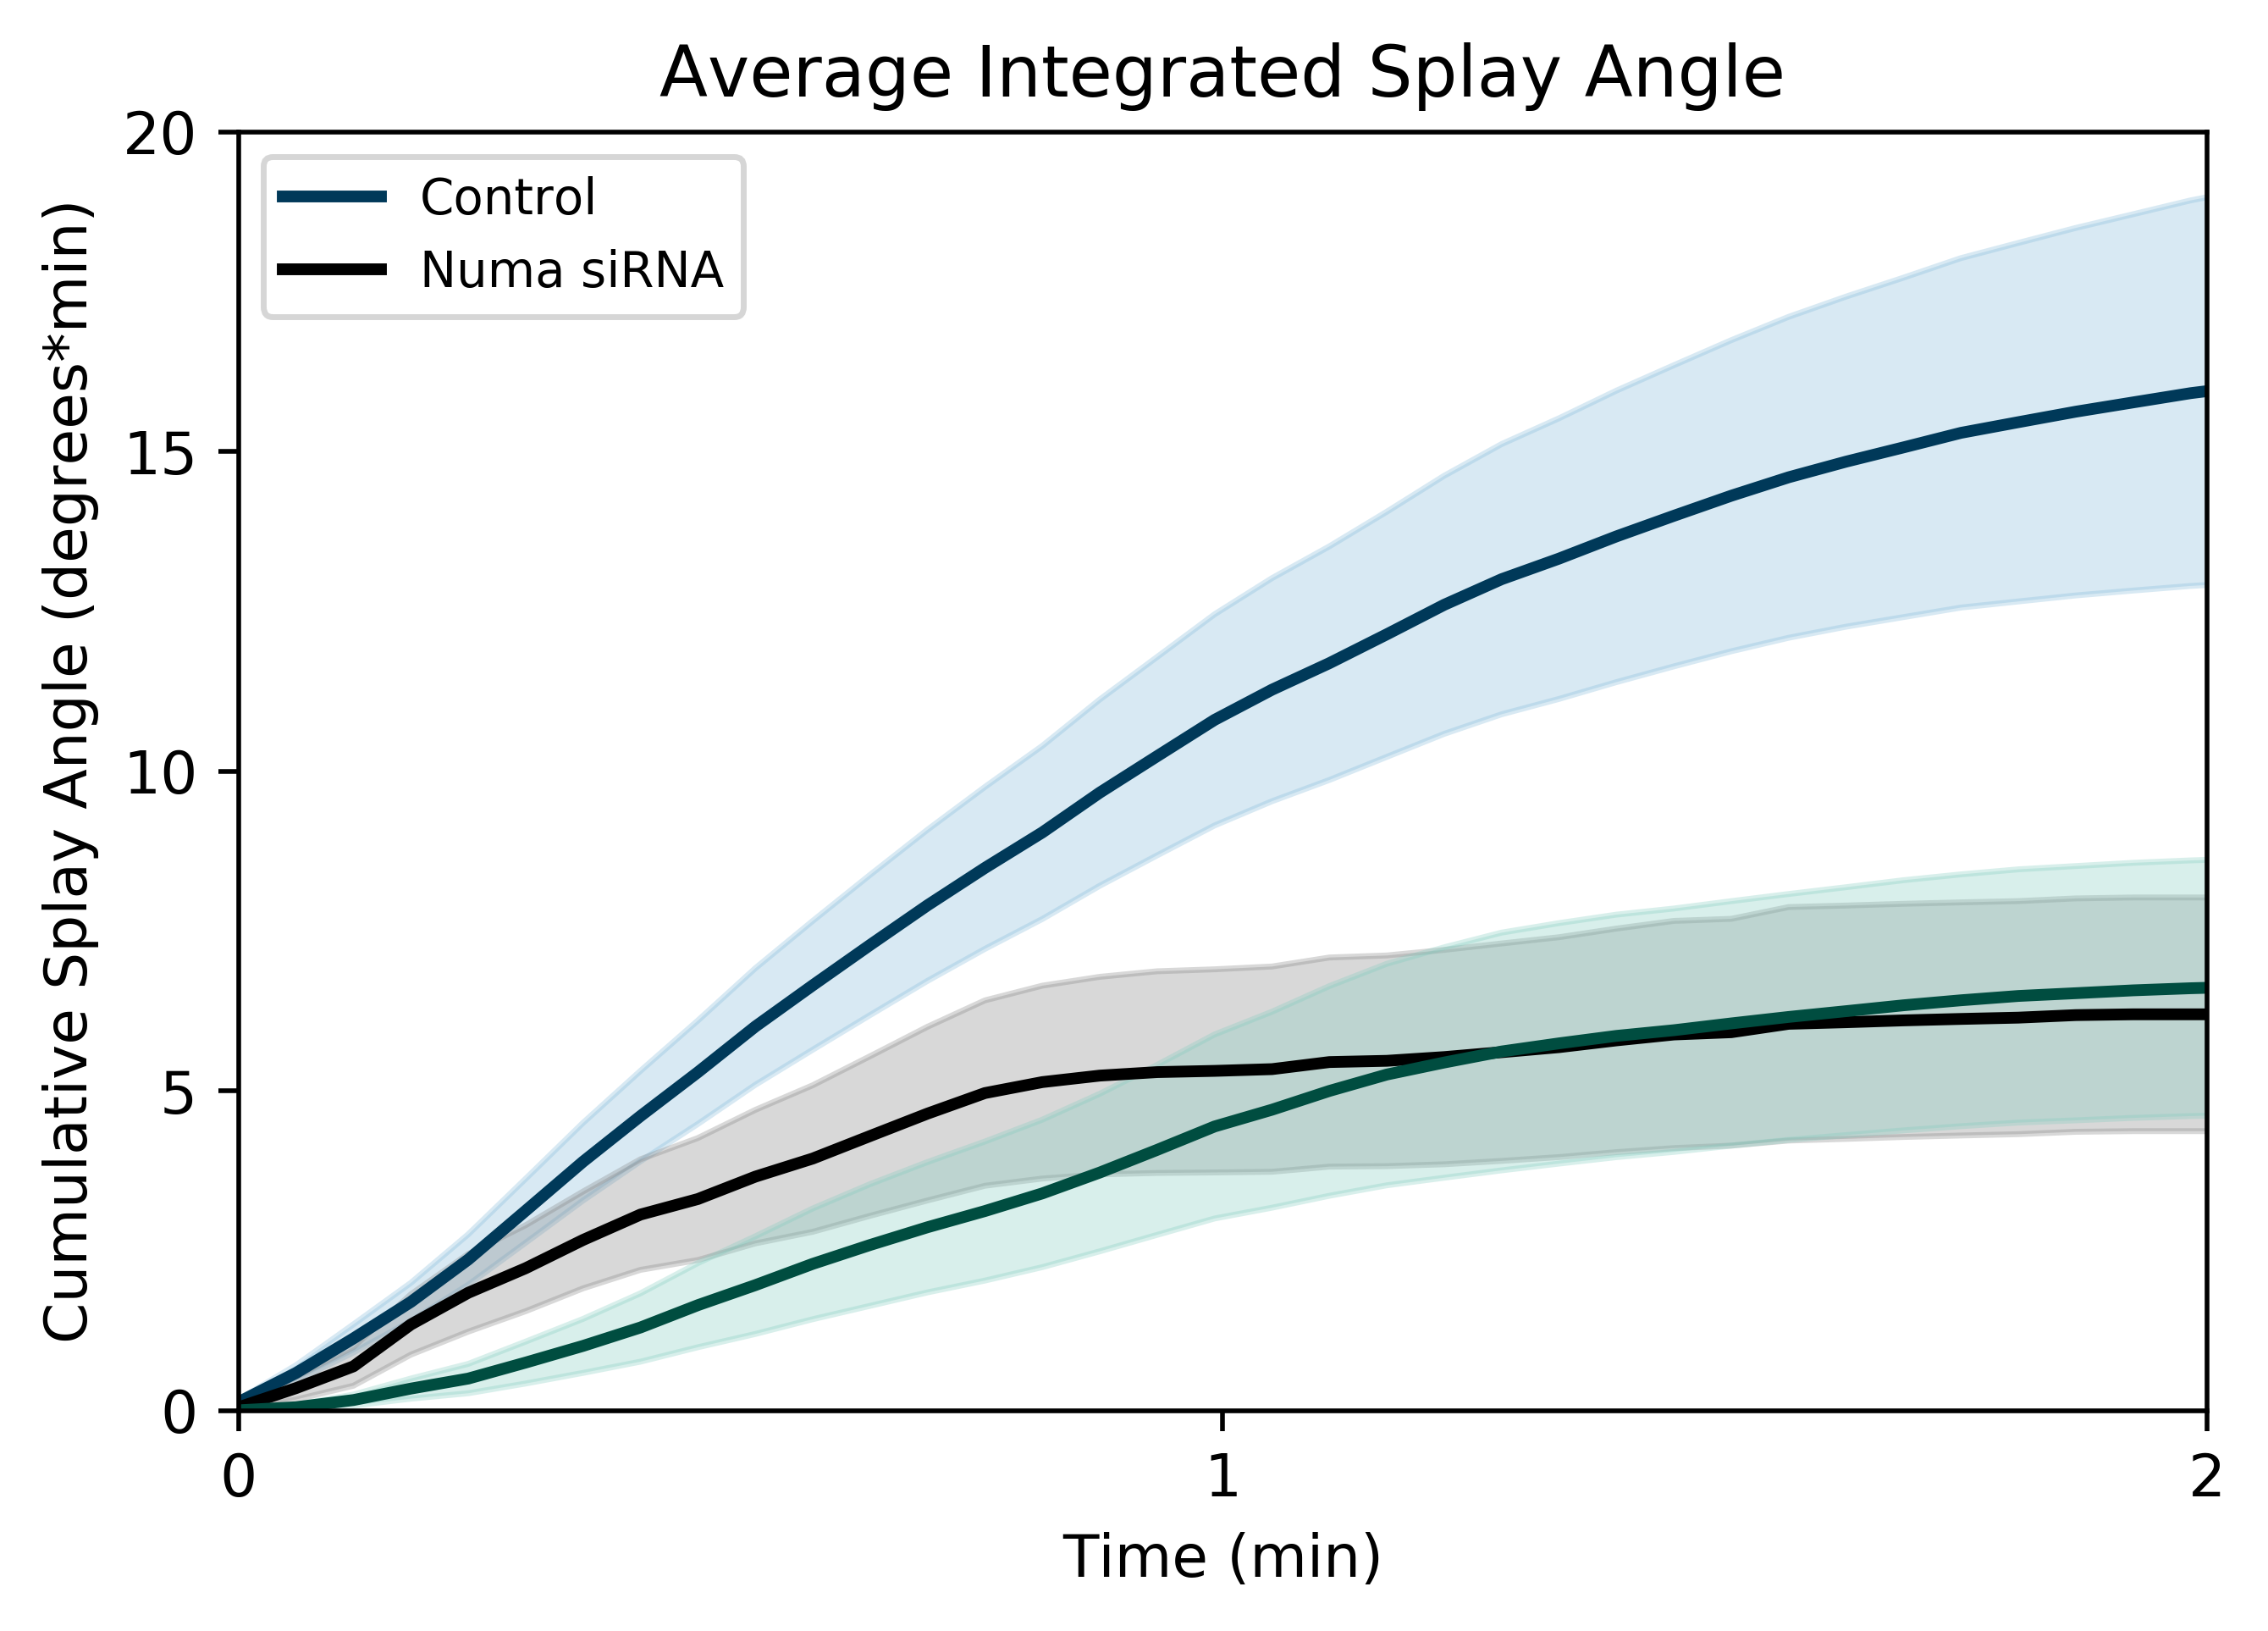

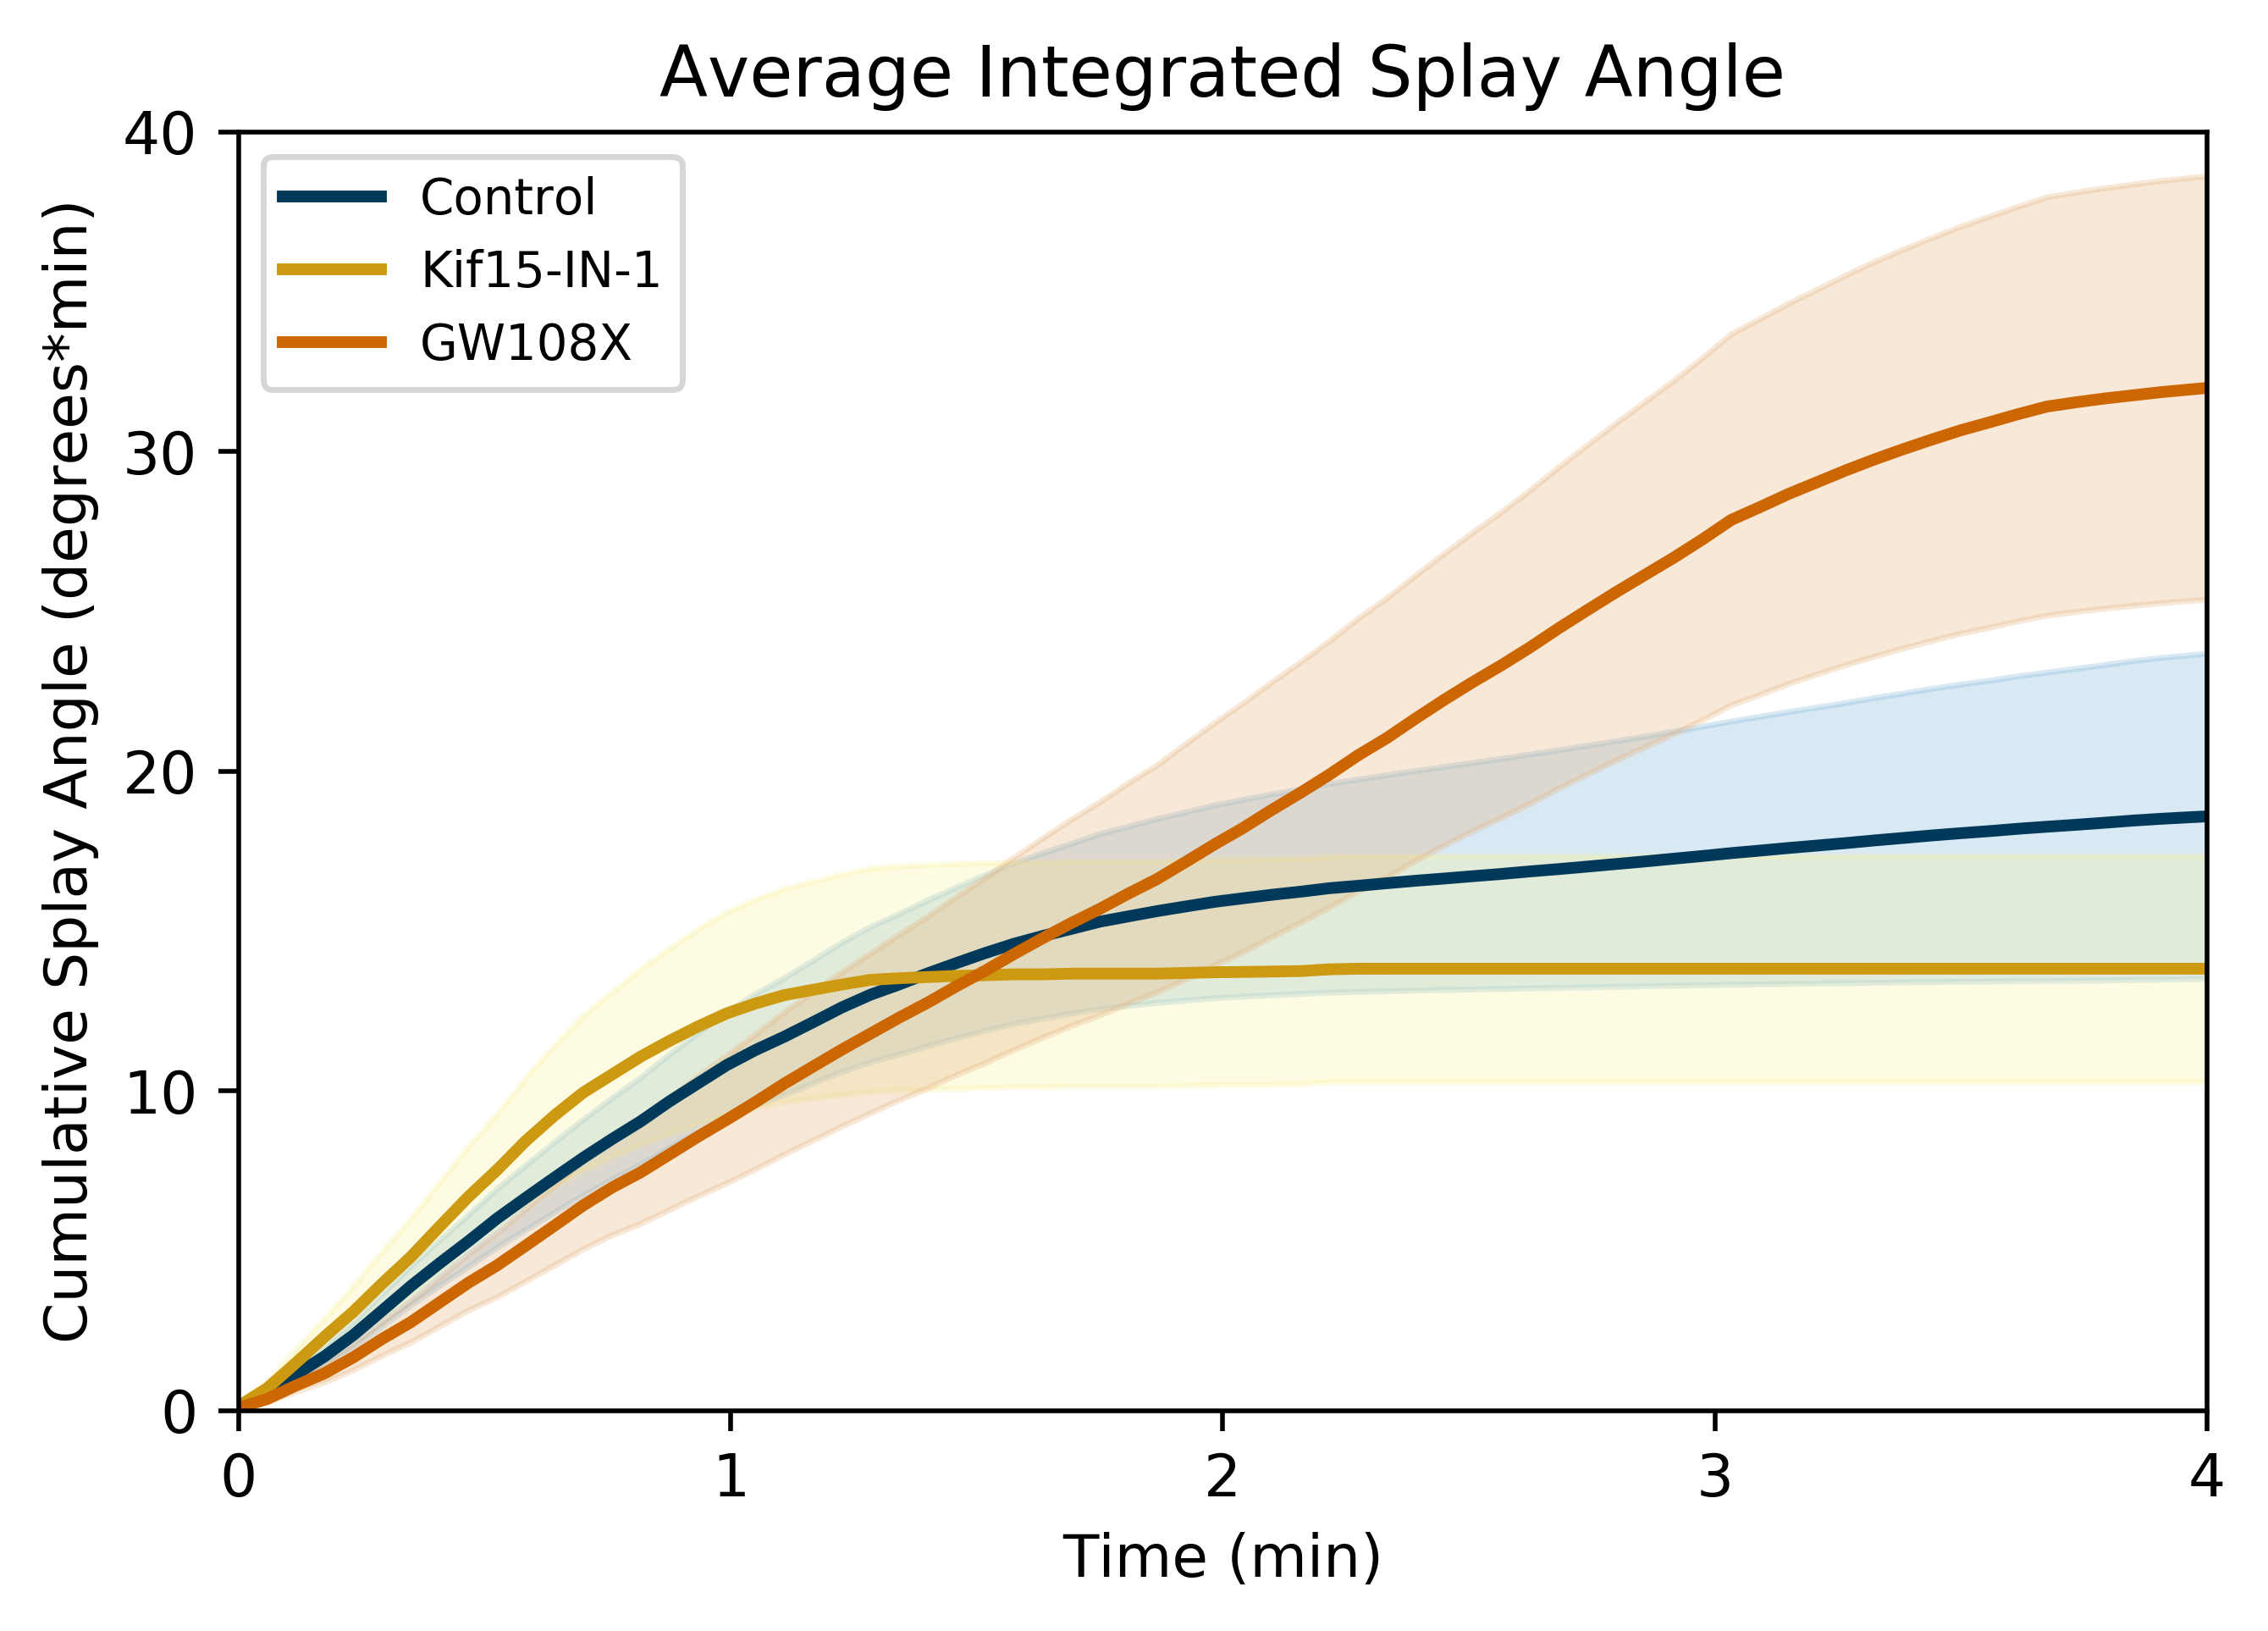

In [12]:
lines = []
plt.figure(dpi=500)
for i in range(3):
    lines.append(plt.plot(tAvgTimes[i], tAvgInts[i], color=colors[i], lw=2))
    plt.fill_between(tAvgTimes[i], tLowInts[i], tHighInts[i], color=fillColors[i], alpha=0.3)
plt.xlim(0,2)
plt.xticks([0,1,2])
plt.ylim(0,20)
plt.yticks([0,5,10,15,20])
plt.title('Average Integrated Splay Angle')
plt.xlabel('Time (min)')
plt.ylabel('Cumulative Splay Angle (degrees*min)')
plt.legend(lines, labels=namesNuMA, loc='upper left', fontsize='small')
plt.savefig('2F.eps', format='eps', dpi=1000)
#plt.close()
print(len(angles0[0]), len(angles0[1]), len(angles0[2]))

lines = []
plt.figure(dpi=500)
for i in range(6):
    if i == 0 or i > 3:
        lines.append(plt.plot(tAvgTimes[i], tAvgInts[i], color=colors[i], lw=2))
        plt.fill_between(tAvgTimes[i], tLowInts[i], tHighInts[i], color=fillColors[i], alpha=0.3)
plt.xlim(0,4)
plt.xticks([0,1,2,3,4])
plt.ylim(0,40)
plt.yticks([0,10,20,30,40])
plt.title('Average Integrated Splay Angle')
plt.xlabel('Time (min)')
plt.ylabel('Cumulative Splay Angle (degrees*min)')
plt.legend(lines, labels=namesK, loc='upper left', fontsize='small')
plt.savefig('3D.eps', format='eps', dpi=1000)
#plt.close()

lines = []
plt.figure(dpi=500)
for i in range(6):
    lines.append(plt.plot(tAvgTimes[i], tAvgInts[i], color=colors[i], lw=2))
    plt.fill_between(tAvgTimes[i], tLowInts[i], tHighInts[i], color=fillColors[i], alpha=0.3)
plt.xlim(0,4)
plt.xticks([0,1,2,3,4])
plt.ylim(0,40)
plt.yticks([0,10,20,30,40])
plt.title('Average Integrated Splay Angle')
plt.xlabel('Time (min)')
plt.ylabel('Cumulative Splay Angle (degrees*min)')
plt.legend(lines, labels=names, loc='upper left', fontsize='small')
#plt.savefig('IntAngleVsIntVel-Kif15.eps', format='eps', dpi=1000)
plt.close()
print(len(angles0[0]), len(angles0[4]), len(angles0[5]))